In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\namo\.cache\kagglehub\datasets\dyutidasmahaptra\s-and-p-500-with-financial-news-headlines-20082024\versions\1


In [243]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import json
import datetime
from datetime import date, timedelta
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Set visualization style
sns.set(style='whitegrid', palette='muted', color_codes=True)

# Import additional libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import random
random.seed(42)
np.random.seed(42)
RANDOM_STATE = 42

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

from plot_utils import *

In [3]:
# Input file paths from local kagglehub dataset
raw_data_path = os.path.join(path, 'sp500_headlines_2008_2024.csv')

# Load the raw data
def load_raw_data():
    raw_data = pd.read_csv(raw_data_path)
    raw_data['Date'] = pd.to_datetime(raw_data['Date'])
    return raw_data

sp500_headlines_2008_2024 = load_raw_data()
sp500_headlines_2008_2024

,Title,Date,CP
0,"JPMorgan Predicts 2008 Will Be ""Nothing But Net""",2008-01-02,1447.16
1,Dow Tallies Biggest First-session-of-year Poin...,2008-01-02,1447.16
2,2008 predictions for the S&P 500,2008-01-02,1447.16
3,"U.S. Stocks Higher After Economic Data, Monsan...",2008-01-03,1447.16
4,U.S. Stocks Climb As Hopes Increase For More F...,2008-01-07,1416.18
...,...,...,...
19122,REITs vs. Stocks: What Does the Data Say?,2024-03-04,5130.95
19123,"Nasdaq Index, Dow Jones, S&P 500 News: Futures...",2024-03-04,5130.95
19124,"Nasdaq 100, Dow Jones, S&P 500 News: Cautious ...",2024-03-04,5130.95
19125,"Bank of America boosts S&P 500 target to 5,400...",2024-03-04,5130.95


In [4]:
sp500_headlines_2008_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19127 entries, 0 to 19126
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Title   19127 non-null  object        
 1   Date    19127 non-null  datetime64[ns]
 2   CP      19127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 448.4+ KB


In [5]:
sp500_headlines_2008_2024.duplicated().sum()

974

<Axes: >

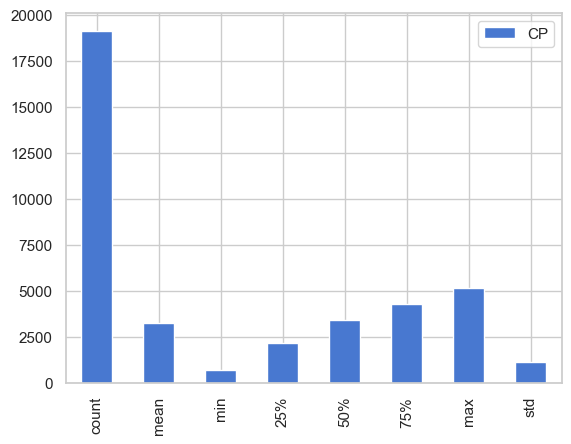

In [6]:
sp500_headlines_2008_2024.describe().plot(kind='bar')

<Axes: xlabel='Date', ylabel='CP'>

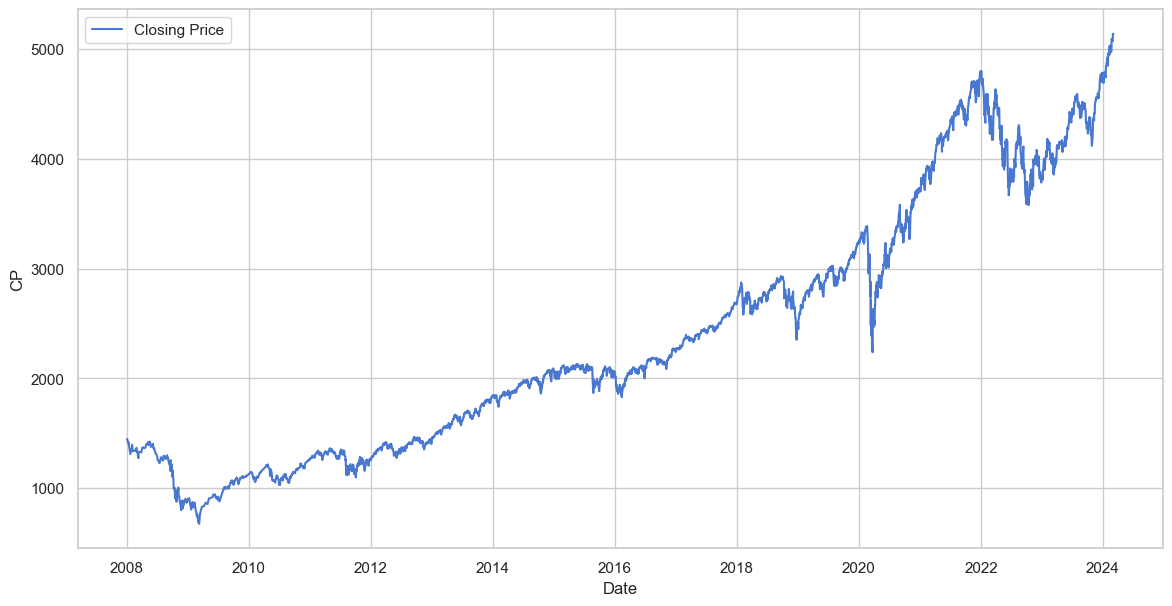

In [7]:
# Plot index prices over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024, label='Closing Price')

Numeric columns: Index(['CP'], dtype='object')


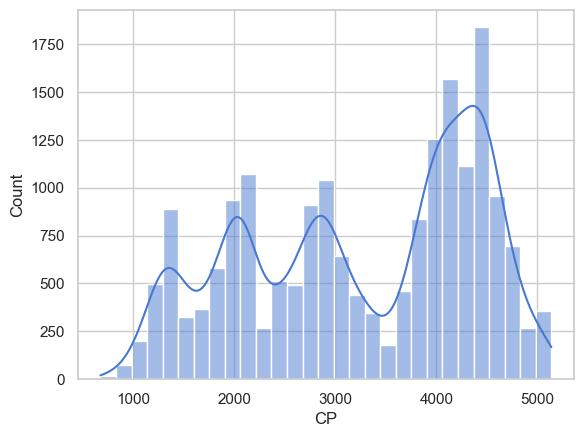

In [8]:
numeric_cols = sp500_headlines_2008_2024.select_dtypes(include=['number']).columns
print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    sns.histplot(x=col, data=sp500_headlines_2008_2024, kde=True)
    plt.show()

## Prepare sentiment data

In [9]:
# Limit the dataset by number of rows for testing
max_rows = len(sp500_headlines_2008_2024)

In [10]:
# Load FinBERT (pre-trained for financial sentiment)
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Custom score: Positive = +1, Neutral = 0, Negative = -1
    score = (probs[0][2] - probs[0][0]).item()
    return score

# Generate sentiment scores
# For testing purposes, we can limit the number of rows processed
sp500_headlines_2008_2024_test = sp500_headlines_2008_2024.head(max_rows)
tqdm.pandas()
sp500_headlines_2008_2024_test['sentiment_score_finbert'] = sp500_headlines_2008_2024_test['Title'].progress_apply(get_sentiment_score)

print(sp500_headlines_2008_2024_test[['Date', 'Title', 'sentiment_score_finbert']].head())

100%|██████████| 19127/19127 [12:18<00:00, 25.90it/s]

        Date                                              Title  \
0 2008-01-02   JPMorgan Predicts 2008 Will Be "Nothing But Net"   
1 2008-01-02  Dow Tallies Biggest First-session-of-year Poin...   
2 2008-01-02                   2008 predictions for the S&P 500   
3 2008-01-03  U.S. Stocks Higher After Economic Data, Monsan...   
4 2008-01-07  U.S. Stocks Climb As Hopes Increase For More F...   

   sentiment_score_finbert  
0                 0.019026  
1                 0.014999  
2                 0.771308  
3                -0.787446  
4                -0.338189  


In [11]:
tt = sp500_headlines_2008_2024.head(1)

inputs = tokenizer(tt['Title'][0], return_tensors="pt", truncation=True)
outputs = model(**inputs)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

print(probs)

# Custom score: Positive = +1, Neutral = 0, Negative = -1
score = (probs[0][2] - probs[0][0]).item()

print(score)

tensor([[0.1884, 0.6042, 0.2074]], grad_fn=<SoftmaxBackward0>)
0.0190257728099823


In [12]:
# Define volatility period
volatility_period = [5, 22, 66, 132, 252]  # 5 days, 22 days (1 month), 66 days (3 months), 132 days (6 months)

# Daily average sentiment
daily_sentiment = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_score_finbert': 'avg_sentiment_score_a_day'}, inplace=True)

# Calculate rolling n-day sentiment volatility (std deviation)
# a week, a month, a quarter, and half a year
for n in volatility_period:
    daily_sentiment[f'{n}_day_sentiment_volatility'] = daily_sentiment['avg_sentiment_score_a_day'].rolling(window=n).std()

print(daily_sentiment)

           Date  avg_sentiment_score_a_day  5_day_sentiment_volatility  \
0    2008-01-02                   0.268444                         NaN   
1    2008-01-03                  -0.787446                         NaN   
2    2008-01-07                  -0.338189                         NaN   
3    2008-01-09                   0.464082                         NaN   
4    2008-01-10                  -0.367122                    0.510163   
...         ...                        ...                         ...   
3502 2024-02-27                   0.151627                    0.273903   
3503 2024-02-28                   0.247577                    0.273043   
3504 2024-02-29                   0.054997                    0.260560   
3505 2024-03-01                  -0.280157                    0.201183   
3506 2024-03-04                   0.069991                    0.199239   

      22_day_sentiment_volatility  66_day_sentiment_volatility  \
0                             NaN            

In [13]:
# Percentages of each sentiment group by >0, <0, and ==0
def sentiment_percentage(df, column):
    total = len(df)
    positive = len(df[df[column] > 0])
    negative = len(df[df[column] < 0])
    neutral = len(df[df[column] == 0])
    
    return {
        'positive': positive / total * 100,
        'negative': negative / total * 100,
        'neutral': neutral / total * 100
    }

sentiment_stats = sentiment_percentage(daily_sentiment, 'avg_sentiment_score_a_day')
print("Sentiment Statistics:", sentiment_stats)

Sentiment Statistics: {'positive': 90.64727687482178, 'negative': 9.352723125178215, 'neutral': 0.0}


## Prepare market data

In [14]:
# Function to label future crash events based on future close prices
def add_future_crash_label(df, look_ahead_days=252, drop_threshold=0.9, close_col="CP"):
    df = df.copy()
    df["future_close"] = df[close_col].shift(-look_ahead_days)
    df["future_crash"] = (df["future_close"] < df[close_col] * drop_threshold).astype(int)
    return df

# Define look-ahead days and drop threshold
# Number of trading days in a year approximately 252 days
look_ahead_days = 252

# Future close price from today is less than drop_threshold% of the current close price
drop_threshold = 0.9

sp500_headlines_2008_2024_test = add_future_crash_label(sp500_headlines_2008_2024_test, look_ahead_days, drop_threshold)
sp500_headlines_2008_2024_test[['Date', 'CP', 'future_close', 'future_crash']]

,Date,CP,future_close,future_crash
0,2008-01-02,1447.16,1126.42,1
1,2008-01-02,1447.16,1126.42,1
2,2008-01-02,1447.16,1136.52,1
3,2008-01-03,1447.16,1136.52,1
4,2008-01-07,1416.18,1136.52,1
...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0
19123,2024-03-04,5130.95,NaN,0
19124,2024-03-04,5130.95,NaN,0
19125,2024-03-04,5130.95,NaN,0


In [15]:
# Count future crash
crashed = sp500_headlines_2008_2024_test['future_crash'].value_counts()[1]
not_crashed = sp500_headlines_2008_2024_test['future_crash'].value_counts()[0]
print(crashed, not_crashed)

print(f'Ratio of crashed: {round(crashed/(crashed + not_crashed) * 100, 2)} %')

807 18320
Ratio of crashed: 4.22 %


With the sentiment statistic calculated before (negative 9.35%), it's quite reasonable with these ratio of crashes (4.22%) to be related to each other.

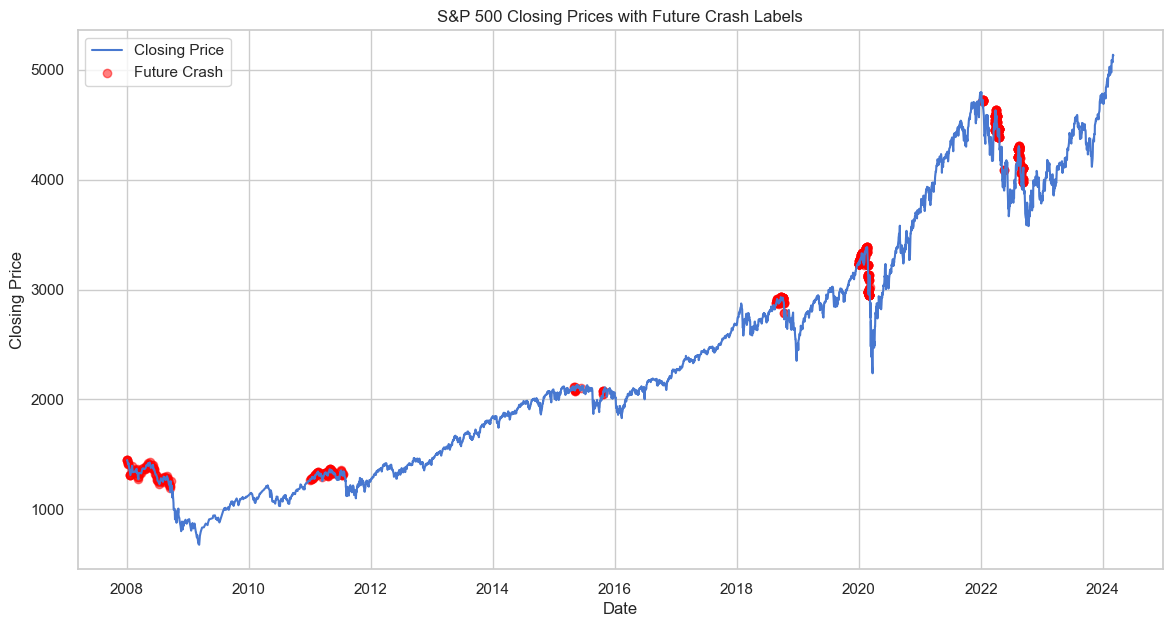

In [16]:
# Plot close prices and future crash labels
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024_test, label='Closing Price')
plt.scatter(sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['future_crash'] == 1]['Date'],
            sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['future_crash'] == 1]['CP'],
            color='red', label='Future Crash',alpha=0.5)
plt.title('S&P 500 Closing Prices with Future Crash Labels')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [17]:
# Print 'index' of last date with future crash label = 1
print("Last date with future crash label = 1:", sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['future_crash'] == 1].index[-1])

# Count data points in each year
print("Data points in each year:")
print(sp500_headlines_2008_2024_test['Date'].dt.year.value_counts().sort_index())

Last date with future crash label = 1: 12732
Data points in each year:
Date
2008     141
2009     113
2010     209
2011     547
2012     724
2013     776
2014     858
2015     818
2016     813
2017     706
2018     840
2019    1848
2020    1519
2021    1303
2022    2319
2023    4760
2024     833
Name: count, dtype: int64


In [18]:
# Ratio of data points before and after 2022
before_2022 = len(sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['Date'] < '2022-01-01'])
after_2022 = len(sp500_headlines_2008_2024_test[sp500_headlines_2008_2024_test['Date'] >= '2022-01-01'])
print(f"Data points before 2022: {before_2022}, after 2022: {after_2022}") 
print(f"Ratio of data points before 2022: {before_2022 / (before_2022 + after_2022) * 100:.2f}%")

# Ratio of crash data before and after 2022
crashed_before_2022 = len(sp500_headlines_2008_2024_test[(sp500_headlines_2008_2024_test['Date'] < '2022-01-01') & (sp500_headlines_2008_2024_test['future_crash'] == 1)])
crashed_after_2022 = len(sp500_headlines_2008_2024_test[(sp500_headlines_2008_2024_test['Date'] >= '2022-01-01') & (sp500_headlines_2008_2024_test['future_crash'] == 1)])
print(f"Crashes before 2022: {crashed_before_2022}, after 2022: {crashed_after_2022}")
print(f"Ratio of crashes before 2022: {crashed_before_2022 / (crashed_before_2022 + crashed_after_2022) * 100:.2f}%")

Data points before 2022: 11215, after 2022: 7912
Ratio of data points before 2022: 58.63%
Crashes before 2022: 539, after 2022: 268
Ratio of crashes before 2022: 66.79%


In [19]:
# Calculate daily returns
sp500_headlines_2008_2024_test['daily_return'] = sp500_headlines_2008_2024_test['CP'].pct_change() * 100  # Convert to percentage

# Prepare market data
market_data = sp500_headlines_2008_2024_test[['Date', 'CP', 'future_close', 'future_crash', 'daily_return']].copy()
market_data['Date'] = pd.to_datetime(market_data['Date'])

market_data

,Date,CP,future_close,future_crash,daily_return
0,2008-01-02,1447.16,1126.42,1,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000
2,2008-01-02,1447.16,1136.52,1,0.000000
3,2008-01-03,1447.16,1136.52,1,0.000000
4,2008-01-07,1416.18,1136.52,1,-2.140745
...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000
19123,2024-03-04,5130.95,NaN,0,0.000000
19124,2024-03-04,5130.95,NaN,0,0.000000
19125,2024-03-04,5130.95,NaN,0,0.000000


In [20]:
# Calculate n-day returns
def calculate_n_day_returns(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_return'] = data['CP'].pct_change(periods=n) * 100  # Convert to percentage
    return data

market_data = calculate_n_day_returns(market_data, volatility_period)
market_data

,Date,CP,future_close,future_crash,daily_return,5_day_market_return,22_day_market_return,66_day_market_return,132_day_market_return,252_day_market_return
0,2008-01-02,1447.16,1126.42,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000,NaN,NaN,NaN,NaN,NaN
2,2008-01-02,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN
3,2008-01-03,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN
4,2008-01-07,1416.18,1136.52,1,-2.140745,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434
19123,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434
19124,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810
19125,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810


In [21]:
# Calculate n-day volatility
def calculate_n_day_volatility(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_volatility'] = data['daily_return'].rolling(window=n).std() * np.sqrt(n)  # Standard deviation of closing prices
    return data

market_data = calculate_n_day_volatility(market_data, volatility_period)
market_data

,Date,CP,future_close,future_crash,daily_return,5_day_market_return,22_day_market_return,66_day_market_return,132_day_market_return,252_day_market_return,5_day_market_volatility,22_day_market_volatility,66_day_market_volatility,132_day_market_volatility,252_day_market_volatility
0,2008-01-02,1447.16,1126.42,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-02,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-01-03,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-01-07,1416.18,1136.52,1,-2.140745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434,0.0,0.0,0.811438,0.990902,2.491513
19123,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434,0.0,0.0,0.811438,0.990902,2.491513
19124,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810,0.0,0.0,0.811438,0.990902,2.442810
19125,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810,0.0,0.0,0.811438,0.990902,2.442810


## Align market data with sentiment data

In [22]:
# Merge market data with daily sentiment
print(daily_sentiment.shape)
print(market_data.shape)
market_sentiment_data = market_data.merge(daily_sentiment, on='Date', how='left')
market_sentiment_data

(3507, 7)
(19127, 15)


,Date,CP,future_close,future_crash,daily_return,5_day_market_return,22_day_market_return,66_day_market_return,132_day_market_return,252_day_market_return,...,22_day_market_volatility,66_day_market_volatility,132_day_market_volatility,252_day_market_volatility,avg_sentiment_score_a_day,5_day_sentiment_volatility,22_day_sentiment_volatility,66_day_sentiment_volatility,132_day_sentiment_volatility,252_day_sentiment_volatility
0,2008-01-02,1447.16,1126.42,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.268444,NaN,NaN,NaN,NaN,NaN
1,2008-01-02,1447.16,1126.42,1,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.268444,NaN,NaN,NaN,NaN,NaN
2,2008-01-02,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.268444,NaN,NaN,NaN,NaN,NaN
3,2008-01-03,1447.16,1136.52,1,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.787446,NaN,NaN,NaN,NaN,NaN
4,2008-01-07,1416.18,1136.52,1,-2.140745,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.338189,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19122,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434,...,0.0,0.811438,0.990902,2.491513,0.069991,0.199239,0.201547,0.194642,0.178143,0.171921
19123,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.012434,...,0.0,0.811438,0.990902,2.491513,0.069991,0.199239,0.201547,0.194642,0.178143,0.171921
19124,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810,...,0.0,0.811438,0.990902,2.442810,0.069991,0.199239,0.201547,0.194642,0.178143,0.171921
19125,2024-03-04,5130.95,NaN,0,0.000000,0.0,0.0,0.680498,1.211552,2.504810,...,0.0,0.811438,0.990902,2.442810,0.069991,0.199239,0.201547,0.194642,0.178143,0.171921


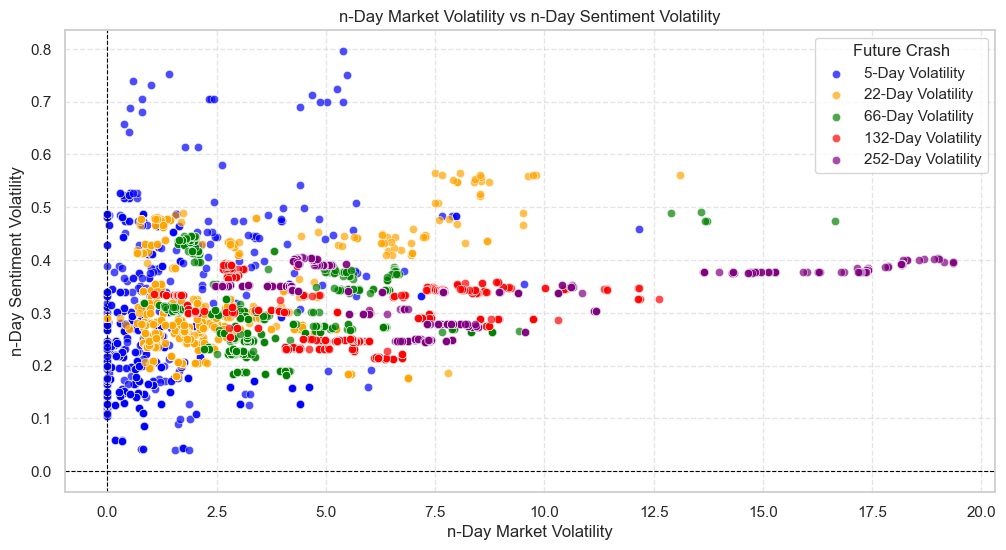

In [23]:
# Plot relationship between future crash and n-day market volatility combined with sentiment volatility
# Plot for 5 day, 22 day, 66 day, and 126 day volatility
crash_data = market_sentiment_data[market_sentiment_data['future_crash'] == 1]

# Scale the market volatility and sentiment volatility for better visualization
def scale_to_0_1(series):
    return (series - series.min()) / (series.max() - series.min())

# for n in volatility_period:
#     crash_data[f'{n}_day_market_volatility'] = scale_to_0_1(crash_data[f'{n}_day_market_volatility'])
    # crash_data[f'{n}_day_sentiment_volatility'] = scale_to_0_1(crash_data[f'{n}_day_sentiment_volatility'])

plt.figure(figsize=(12, 6))
sns.scatterplot(x='5_day_market_volatility', y='5_day_sentiment_volatility', data=crash_data, label='5-Day Volatility', alpha=0.7, color='blue')
sns.scatterplot(x='22_day_market_volatility', y='22_day_sentiment_volatility', data=crash_data, label='22-Day Volatility', alpha=0.7, color='orange')
sns.scatterplot(x='66_day_market_volatility', y='66_day_sentiment_volatility', data=crash_data, label='66-Day Volatility', alpha=0.7, color='green')
sns.scatterplot(x='132_day_market_volatility', y='132_day_sentiment_volatility', data=crash_data, label='132-Day Volatility', alpha=0.7, color='red')
sns.scatterplot(x='252_day_market_volatility', y='252_day_sentiment_volatility', data=crash_data, label='252-Day Volatility', alpha=0.7, color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('n-Day Market Volatility vs n-Day Sentiment Volatility')
plt.xlabel('n-Day Market Volatility')
plt.ylabel('n-Day Sentiment Volatility')
plt.legend(title='Future Crash', loc='upper right')
plt.show()

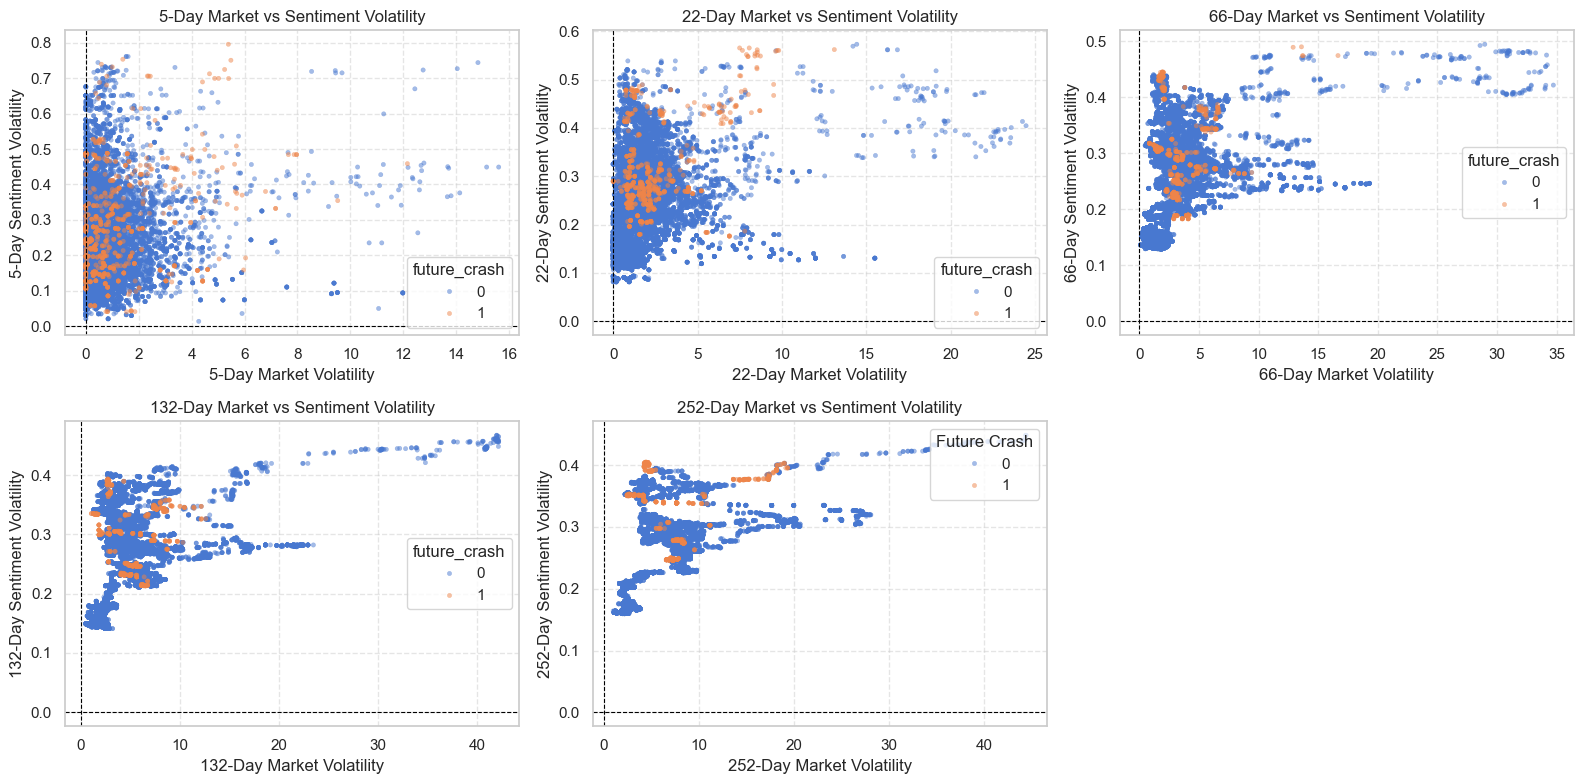

In [24]:
n_cols = 3
n_rows = (len(volatility_period) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

df_sorted = market_sentiment_data.sort_values('future_crash')

for idx, n in enumerate(volatility_period):
    ax = axes[idx]
    x_col = f'{n}_day_market_volatility'
    y_col = f'{n}_day_sentiment_volatility'

    # Drop NA values for clean plot
    df_plot = df_sorted.dropna(subset=[x_col, y_col, 'future_crash'])

    sns.scatterplot(
        x=x_col, y=y_col, hue='future_crash', data=df_plot, alpha=0.5, ax=ax, edgecolor=None, s=10
    )
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_title(f'{n}-Day Market vs Sentiment Volatility')
    ax.set_xlabel(f'{n}-Day Market Volatility')
    ax.set_ylabel(f'{n}-Day Sentiment Volatility')
    ax.grid(True, linestyle='--', alpha=0.5)

# Remove unused subplots
for j in range(len(volatility_period), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.legend(title='Future Crash', loc='upper right')
plt.show()

## Modelling

### Add VaR and ES features

In [25]:
def add_var_es_features(df, return_col='daily_return', windows=volatility_period, confidence=0.05):
    df = df.copy()
    z_score = abs(np.percentile(np.random.normal(size=100000), confidence * 100))  # ≈1.64 for 95%, 1.96 for 97.5%

    for w in windows:
        # Rolling mean and std of returns
        rolling_mu = df[return_col].rolling(window=w).mean()
        rolling_sigma = df[return_col].rolling(window=w).std()

        # Parametric Gaussian VaR (1-day, % return)
        df[f'VaR_{w}'] = - (rolling_mu + z_score * rolling_sigma)

        # Expected Shortfall (ES) assuming normal distribution
        pdf_factor = np.exp(-0.5 * z_score**2) / (np.sqrt(2 * np.pi))
        cdf_factor = confidence
        df[f'ES_{w}'] = - (rolling_mu + (rolling_sigma * pdf_factor / cdf_factor))
    
    return df

market_sentiment_data = add_var_es_features(market_sentiment_data, return_col='daily_return')

In [26]:
market_sentiment_data.columns

Index(['Date', 'CP', 'future_close', 'future_crash', 'daily_return',
       '5_day_market_return', '22_day_market_return', '66_day_market_return',
       '132_day_market_return', '252_day_market_return',
       '5_day_market_volatility', '22_day_market_volatility',
       '66_day_market_volatility', '132_day_market_volatility',
       '252_day_market_volatility', 'avg_sentiment_score_a_day',
       '5_day_sentiment_volatility', '22_day_sentiment_volatility',
       '66_day_sentiment_volatility', '132_day_sentiment_volatility',
       '252_day_sentiment_volatility', 'VaR_5', 'ES_5', 'VaR_22', 'ES_22',
       'VaR_66', 'ES_66', 'VaR_132', 'ES_132', 'VaR_252', 'ES_252'],
      dtype='object')

In [27]:
# Count future crash events
future_crash_counts = market_sentiment_data['future_crash'].value_counts()
print(future_crash_counts)

future_crash
0    18320
1      807
Name: count, dtype: int64


In [28]:
# Handle class imbalance
# Resample the data to balance classes
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=RANDOM_STATE)

# Prepare features and target variable
volatility_period = [5, 22, 66, 132, 252]
target_col = 'future_crash'
model_results = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Drop rows with NaN values in feature columns
    X = market_sentiment_data[feature_cols].dropna()
    y = market_sentiment_data.loc[X.index, target_col]

    X = X.fillna(X.mean())  # Fill NaN values with column means
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE) 
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [248]:
def dynamic_threshold_calculate(y_test, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    # Find threshold for best F1 or based on your risk tolerance
    f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]

    print(f"Best threshold: {best_thresh:.2f}, F1: {f1_scores[best_idx]:.2f}")
    return best_thresh

### RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_results = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Drop rows with NaN values in feature columns
    X = market_sentiment_data[feature_cols].dropna()
    y = market_sentiment_data.loc[X.index, target_col]

    X = X.fillna(X.mean())  # Fill NaN values with column means
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE) 
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    grid.fit(X_resampled, y_resampled)

    print("Best params:", grid.best_params_)
    print("Best AUC on CV:", grid.best_score_)

    # Reuse best model
    rf_model = grid.best_estimator_

    # Predict
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("Best Model ROC AUC:", roc_auc_score(y_test, y_proba))

    # Save everything for later
    rf_results[n] = {
        'model': rf_model,
        'best_params': grid.best_params_,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC on CV: 0.986180710630249
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3664
           1       0.55      0.74      0.63       160

    accuracy                           0.96      3824
   macro avg       0.77      0.86      0.81      3824
weighted avg       0.97      0.96      0.97      3824

Best Model ROC AUC: 0.9358752388100435
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC on CV: 0.9984953844619063
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3664
           1       0.79      0.88      0.83       155

    accuracy                           0.99      3819
   macro avg       0.89    

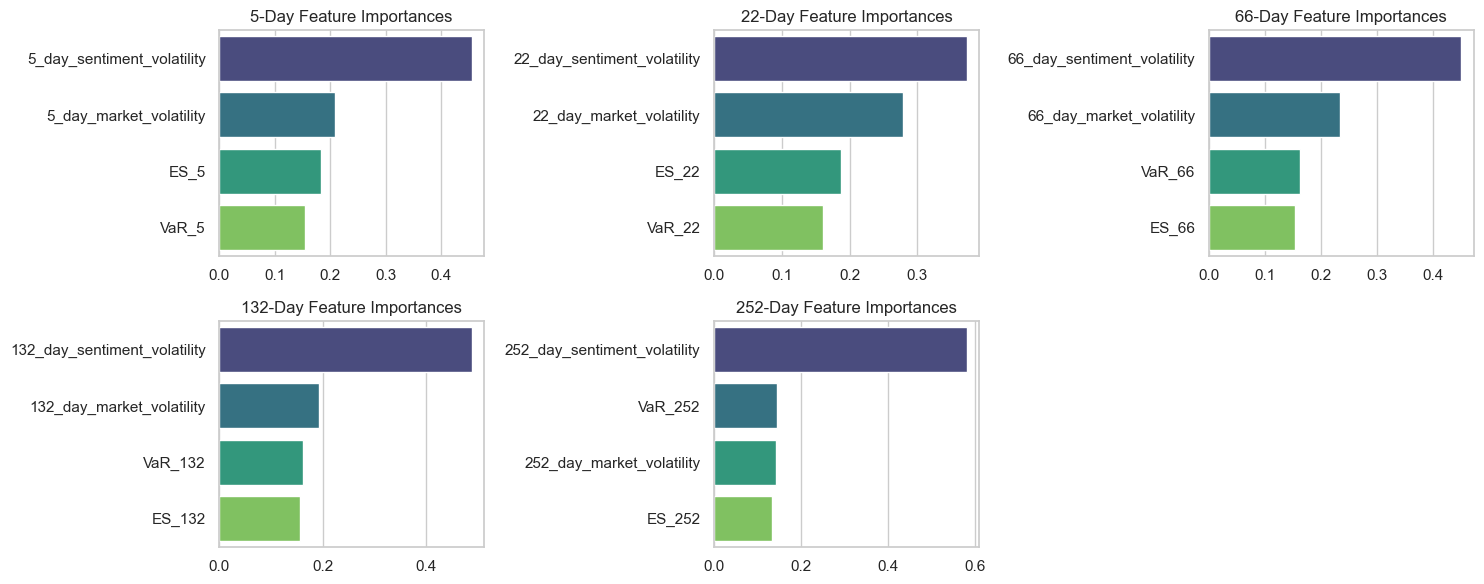

In [30]:
plot_feature_importances_grid(rf_results)

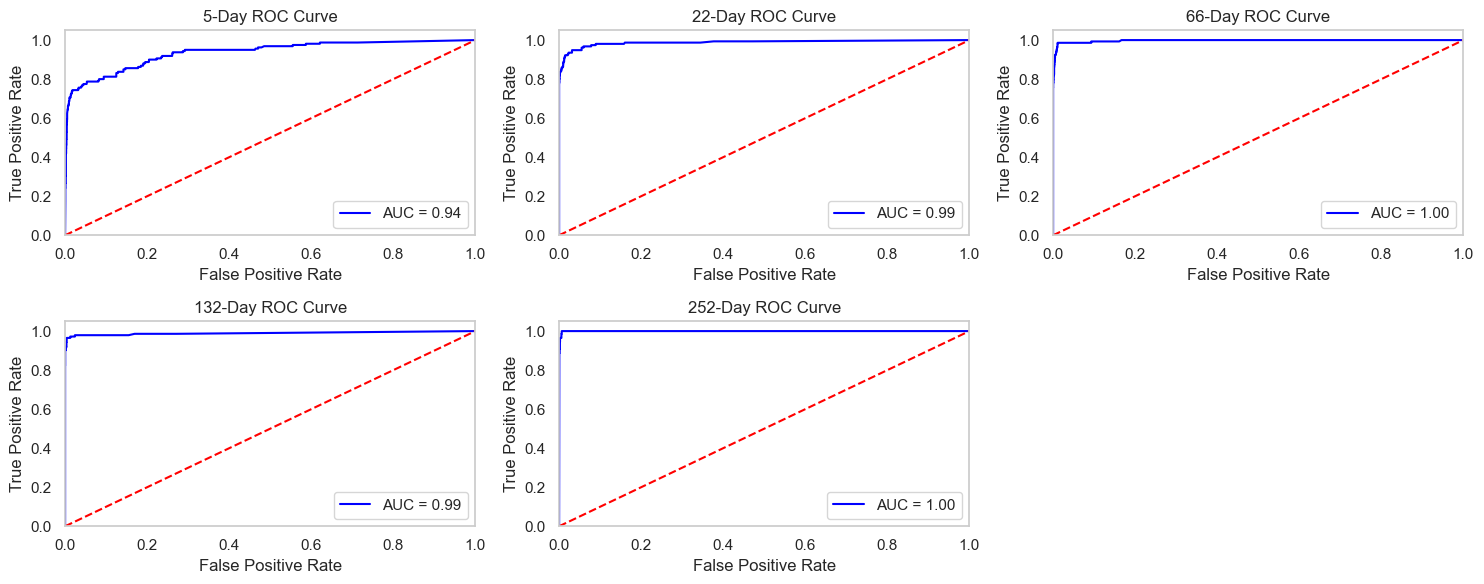

In [31]:
plot_roc_curves_grid(rf_results, X_test_dict, y_test_dict)

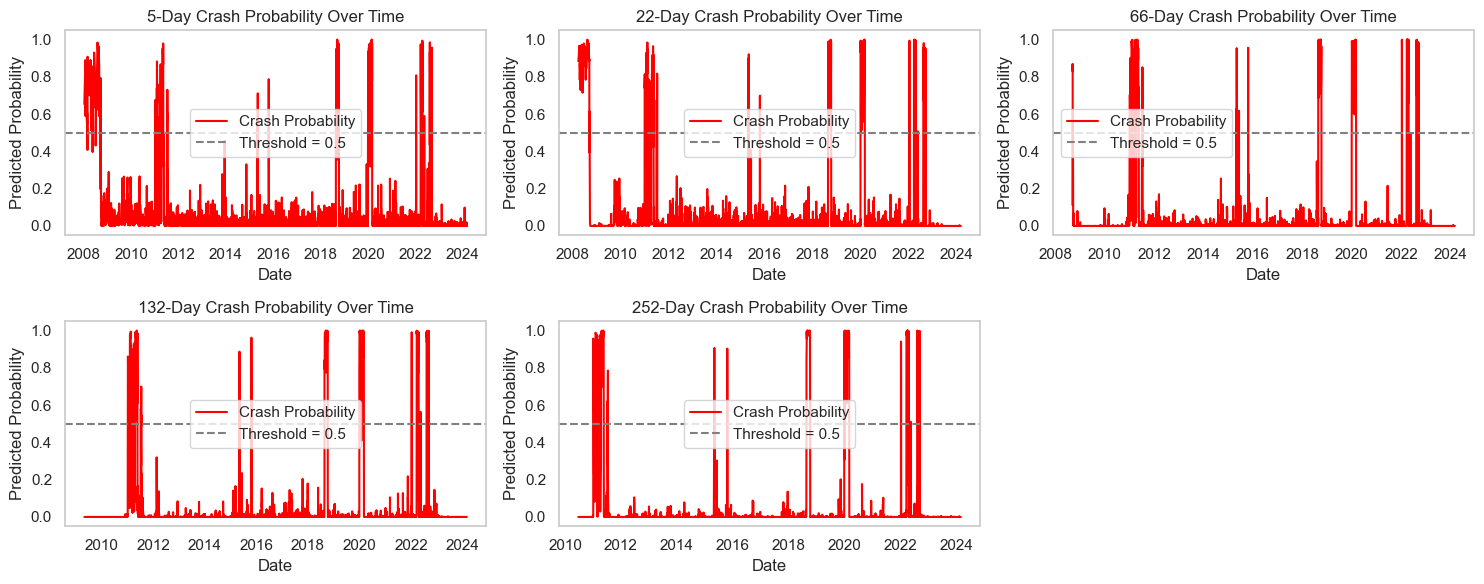

In [32]:
plot_crash_probabilities_grid(rf_results, market_sentiment_data, target_col='future_crash')

### Logit Model

In [33]:
from sklearn.linear_model import LogisticRegression

logit_results = {}
X_test_dict = {}
y_test_dict = {}

sm = SMOTE(random_state=RANDOM_STATE)

volatility_period = [5, 22, 66, 132, 252]  # Define volatility periods

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Drop NA rows for this n
    df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()

    X = df_model[feature_cols]
    y = df_model['future_crash']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE) 
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    logit = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')  # L1/L2 penalty support
    logit.fit(X_resampled, y_resampled)

    y_pred = logit.predict(X_test)
    y_proba = logit.predict_proba(X_test)[:, 1]

     # Save results
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    logit_results[n] = {
        'model': logit,
        'auc': auc_score,
        'report': report,
        'coefficients': coefficients,
    }

    # Store for ROC plotting, etc.
    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    # Optional print
    print(f"\n=== {n}-Day Logit Model ===")
    print(f"AUC: {auc_score:.3f}")
    print("Top coefficients:")
    print(coefficients)


=== 5-Day Logit Model ===
AUC: 0.652
Top coefficients:
                      Feature  Coefficient
1  5_day_sentiment_volatility     2.433540
0     5_day_market_volatility     0.236012
3                        ES_5    -0.030694
2                       VaR_5     0.014043

=== 22-Day Logit Model ===
AUC: 0.691
Top coefficients:
                       Feature  Coefficient
1  22_day_sentiment_volatility     7.349895
2                       VaR_22     0.349706
0     22_day_market_volatility     0.341935
3                        ES_22     0.318806

=== 66-Day Logit Model ===
AUC: 0.667
Top coefficients:
                       Feature  Coefficient
1  66_day_sentiment_volatility     6.903224
2                       VaR_66     0.045390
3                        ES_66     0.045116
0     66_day_market_volatility     0.005249

=== 132-Day Logit Model ===
AUC: 0.706
Top coefficients:
                        Feature  Coefficient
1  132_day_sentiment_volatility     6.908117
2                       VaR

Logistic regression coefficients represent the log odds change in the dependent variable (e.g., financial crash) for a one-unit change in the predictor variable. So:
1. Large positive coefficients → strong positive influence on crash probability.
2. Large negative coefficients → strong negative influence (protective effect).
3. Coefficients near 0 → less influential.

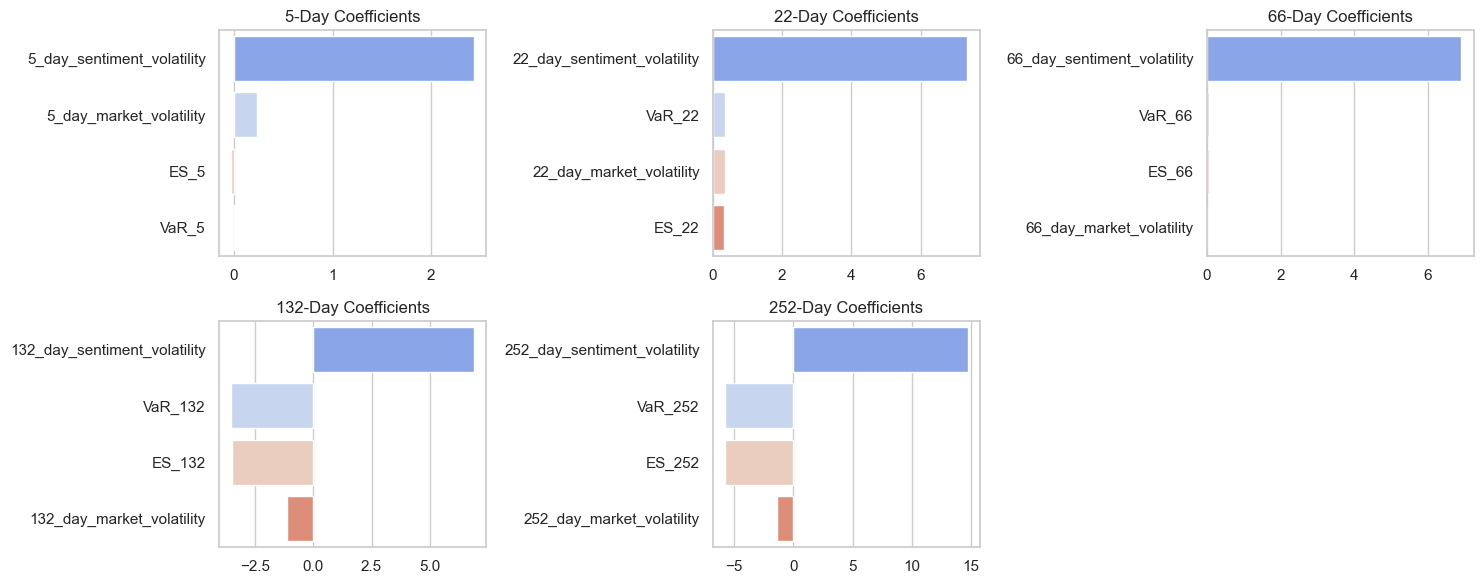

In [34]:
plot_logit_coefficients_grid(logit_results)

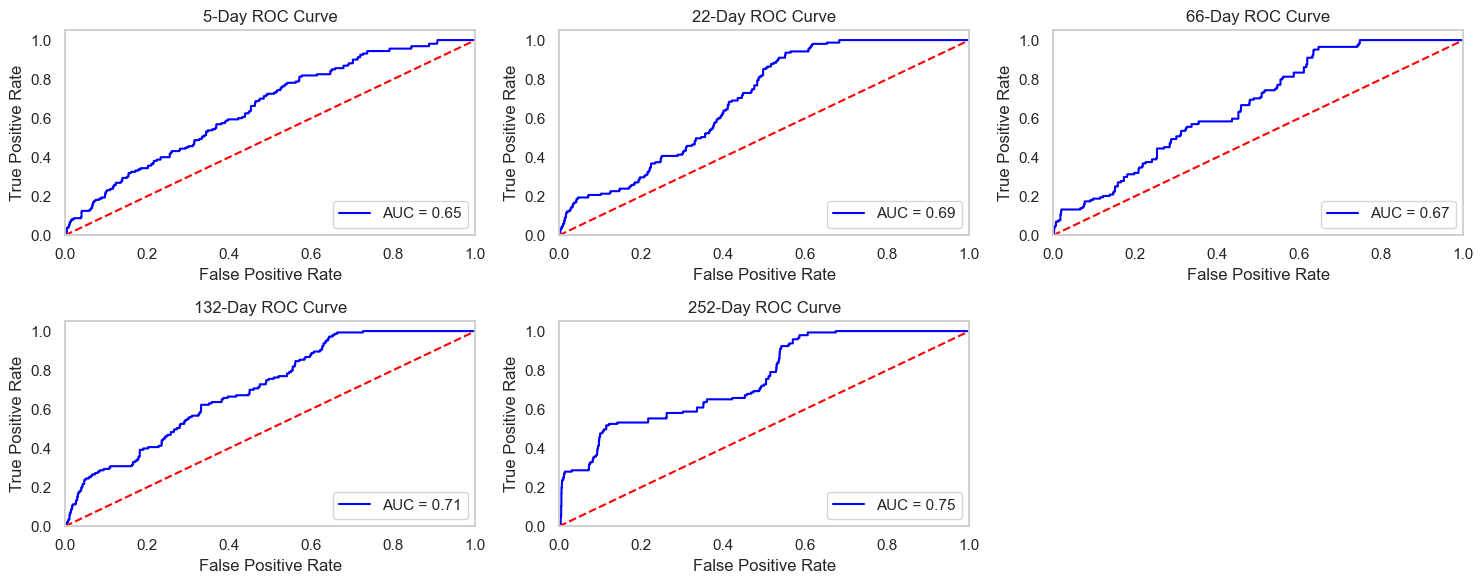

In [35]:
plot_roc_curves_grid(logit_results, X_test_dict, y_test_dict)

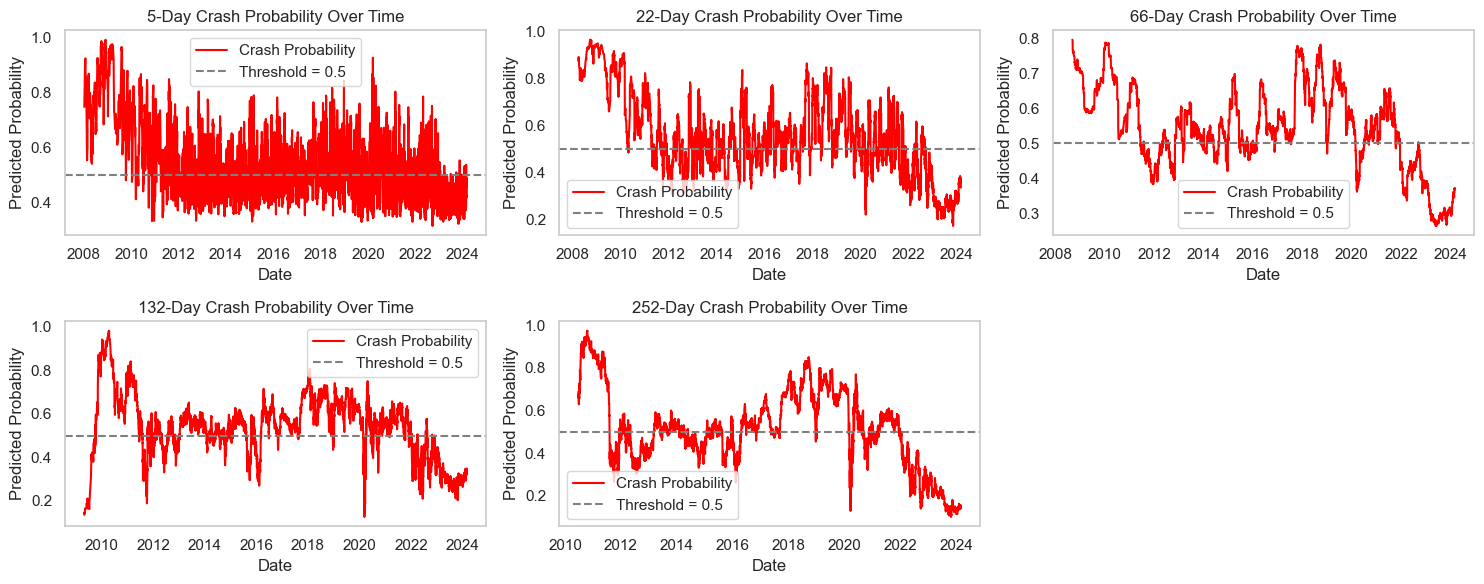

In [36]:
plot_crash_probabilities_grid(logit_results, market_sentiment_data, target_col='future_crash')

### Logit Regression with different sampling method 

In [184]:
logit_results = {}
X_test_dict = {}
y_test_dict = {}

sm = SMOTE(random_state=RANDOM_STATE)

volatility_period = [5, 22, 66, 132, 252]  # Define volatility periods

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Drop NA rows for this n
    df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()

    X = df_model[feature_cols]
    y = df_model['future_crash']
    
    train_size = int(len(df_model) * 0.6)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    X_resampled, y_resampled = X_train.copy(), y_train.copy()

    logit = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000, 
        class_weight='balanced',
        C=1.0,
        l1_ratio=0.5)
    logit.fit(X_resampled, y_resampled)

    y_pred = logit.predict(X_test)
    y_proba = logit.predict_proba(X_test)[:, 1]

     # Save results
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    logit_results[n] = {
        'model': logit,
        'auc': auc_score,
        'report': report,
        'coefficients': coefficients,
    }

    # Store for ROC plotting, etc.
    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    # Optional print
    print(f"\n=== {n}-Day Logit Model ===")
    print(f"AUC: {auc_score:.3f}")
    print("Top coefficients:")
    print(coefficients)


=== 5-Day Logit Model ===
AUC: 0.584
Top coefficients:
                      Feature  Coefficient
0     5_day_market_volatility     0.233365
1  5_day_sentiment_volatility    -0.059977
2                       VaR_5     0.026536
3                        ES_5     0.000000

=== 22-Day Logit Model ===
AUC: 0.926
Top coefficients:
                       Feature  Coefficient
1  22_day_sentiment_volatility     4.011162
2                       VaR_22     0.315672
3                        ES_22     0.276551
0     22_day_market_volatility     0.272569

=== 66-Day Logit Model ===
AUC: 0.773
Top coefficients:
                       Feature  Coefficient
1  66_day_sentiment_volatility     7.786112
2                       VaR_66     1.476891
3                        ES_66     1.431910
0     66_day_market_volatility     0.593676

=== 132-Day Logit Model ===
AUC: 0.902
Top coefficients:
                        Feature  Coefficient
1  132_day_sentiment_volatility     7.978665
2                       VaR

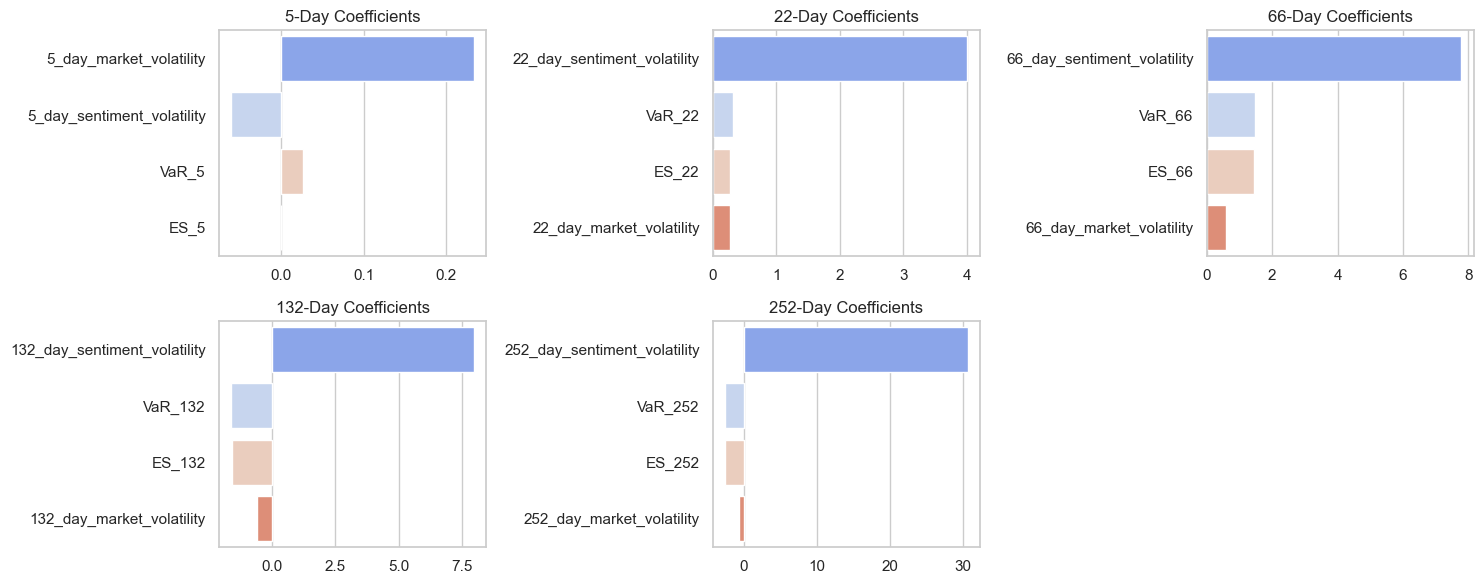

In [185]:
plot_logit_coefficients_grid(logit_results)

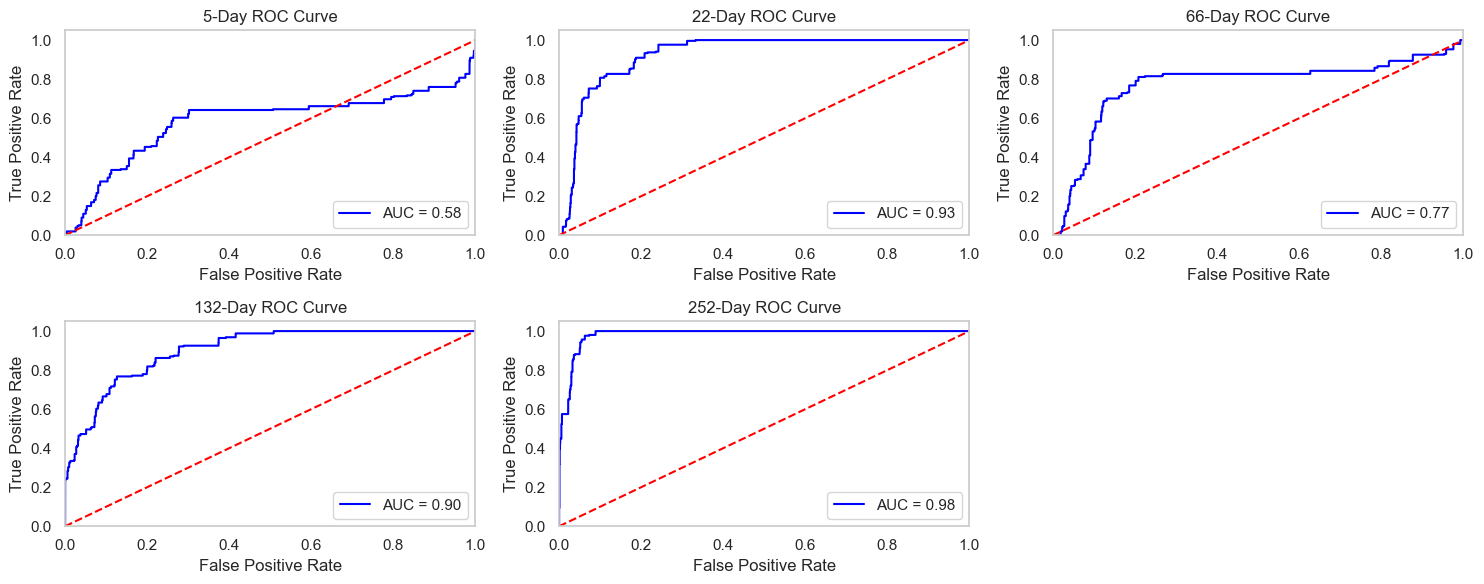

In [186]:
plot_roc_curves_grid(logit_results, X_test_dict, y_test_dict)

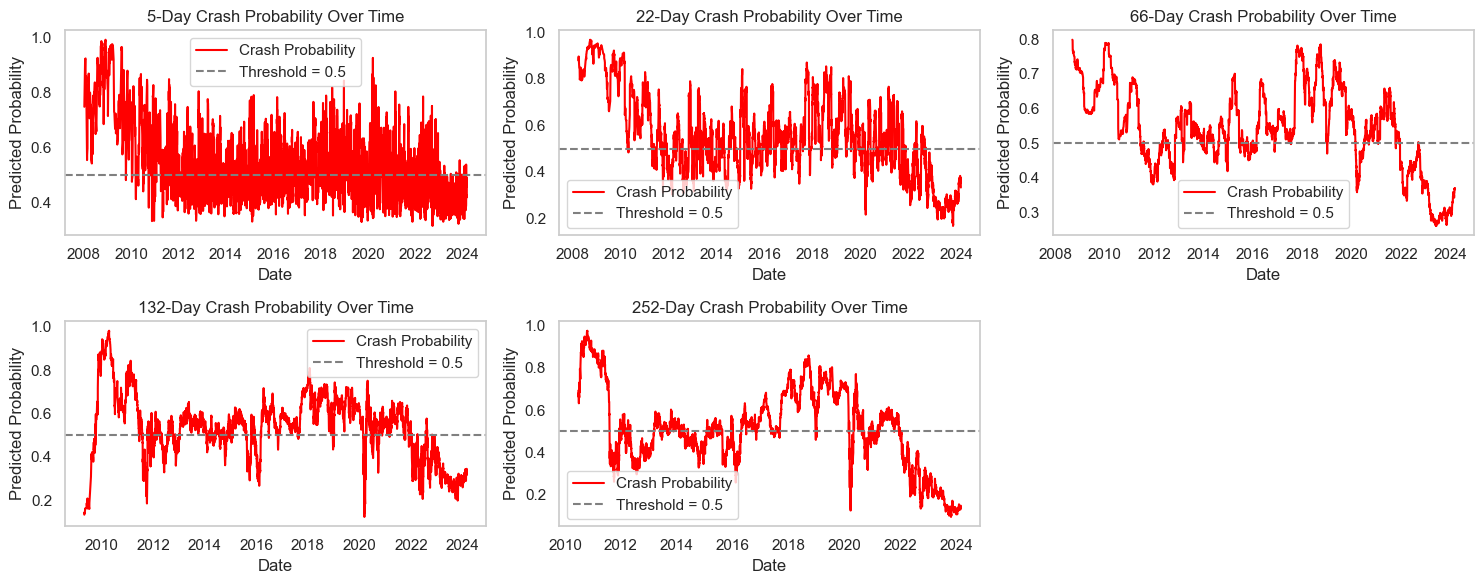

In [187]:
plot_crash_probabilities_grid(logit_results, market_sentiment_data, target_col='future_crash')

### Logit Regression with combined sentiment features

In [188]:
# Define combined feature period
combined_period = 0

# Combine 5-day and 22-day features
combined_features = [
    # f'5_day_sentiment_volatility',
    f'22_day_sentiment_volatility',
    # f'66_day_sentiment_volatility',
    # f'132_day_sentiment_volatility',
    # f'252_day_sentiment_volatility',
    # f'VaR_5',
    f'VaR_22',
    # f'VaR_66',
    # f'VaR_132',
    # f'VaR_252',
]

# Drop NA rows for these features
df_combined = market_sentiment_data.dropna(subset=combined_features + ['future_crash']).copy()

X = df_combined[combined_features]
y = df_combined['future_crash']

# Split and apply SMOTE
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)
train_size = int(len(df_model) * 0.6)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
# X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
X_resampled, y_resampled = X_train.copy(), y_train.copy()

# Fit logistic regression
logit = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=1000, 
    class_weight='balanced',
    C=1.0,
    l1_ratio=0.5)
logit.fit(X_resampled, y_resampled)

y_pred = logit.predict(X_test)
y_proba = logit.predict_proba(X_test)[:, 1]

# Evaluation
auc_score = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, output_dict=True)

coefficients = pd.DataFrame({
    'Feature': combined_features,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Store results
logit_results[combined_period] = {
    'model': logit,
    'auc_score': auc_score,
    'report': report,
    'coefficients': coefficients,
}

X_test_dict[combined_period] = X_test
y_test_dict[combined_period] = y_test

# Print summary
print(f"\n=== Combined Logit Model ===")
print(f"AUC: {auc_score:.3f}")
print("Top coefficients:")
print(coefficients)


=== Combined Logit Model ===
AUC: 0.943
Top coefficients:
                       Feature  Coefficient
0  22_day_sentiment_volatility     3.776653
1                       VaR_22    -0.118725


Precision and Recall for Combined Model:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7355
           1       0.09      0.05      0.06       254

    accuracy                           0.95      7609
   macro avg       0.53      0.52      0.52      7609
weighted avg       0.94      0.95      0.95      7609



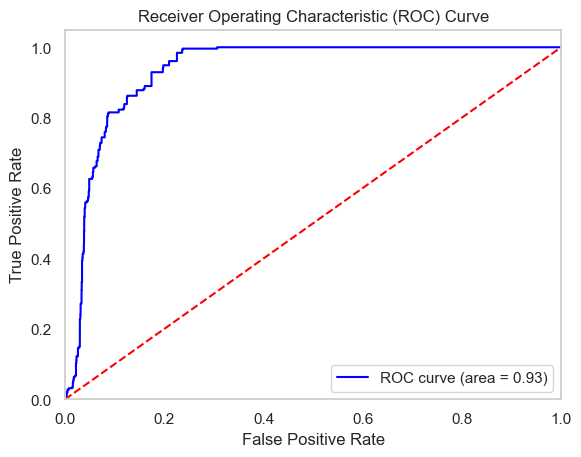

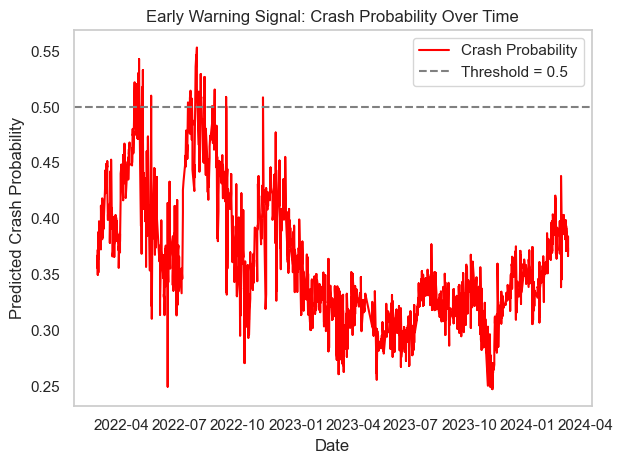

In [239]:
# Create DataFrame with dates and probabilities
dates = df_combined.loc[X_test.index, 'Date']
prob_df = pd.DataFrame({
    'Date': dates,
    'crash_probability': y_proba
}).sort_values('Date')

# Report precision and recall
print("Precision and Recall for Combined Model:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
plot_roc_curve(y_test, y_proba)

# Plot crash probabilities
plot_crash_probabilities(prob_df, target_col='crash_probability')

### Dynamic Logit Regression

In [254]:
logit_results = {}
X_test_dict = {}
y_test_dict = {}

sm = SMOTE(random_state=RANDOM_STATE)
lag = 10  # ← dynamic variable
volatility_period = [5, 22, 66, 132, 252]

for n in volatility_period:
    # Base features
    base_features = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Add lagged features
    for feat in base_features:
        market_sentiment_data[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

    feature_cols = base_features + [f'{f}_lag{lag}' for f in base_features]

    # Drop NA rows for lagged features and future crash label
    df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()
    
    X = df_model[feature_cols]
    y = df_model['future_crash']

    # Train/test split
    # X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

    # Example: Train on past, test on future (rolling window setup)
    train_size = int(len(df_model) * 0.6)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Oversample
    # X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    X_resampled, y_resampled = X_train.copy(), y_train.copy()

    # Fit logistic regression
    logit = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
    logit.fit(X_resampled, y_resampled)

    # Predict
    y_proba = logit.predict_proba(X_test)[:, 1]
    best_thresh = dynamic_threshold_calculate(y_test, y_proba)
    y_pred = (y_proba >= best_thresh).astype(int)
    # y_pred = logit.predict(X_test)
    
    # Save results
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    logit_results[n] = {
        'model': logit,
        'auc': auc_score,
        'report': report,
        'coefficients': coefficients,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day Logit Model with Lag {lag} ===")
    print(f"AUC: {auc_score:.3f}")
    print("Top coefficients:")
    print(coefficients.head())

Best threshold: 0.49, F1: 0.12

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.550
Top coefficients:
                            Feature  Coefficient
5  5_day_sentiment_volatility_lag10    -0.654551
4     5_day_market_volatility_lag10     0.227055
0           5_day_market_volatility     0.186176
6                       VaR_5_lag10     0.116956
1        5_day_sentiment_volatility     0.113881
Best threshold: 0.45, F1: 0.40

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.915
Top coefficients:
                             Feature  Coefficient
5  22_day_sentiment_volatility_lag10     2.321446
1        22_day_sentiment_volatility     1.920297
0           22_day_market_volatility     0.282355
2                             VaR_22     0.268750
3                              ES_22     0.243235
Best threshold: 0.33, F1: 0.21

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.743
Top coefficients:
                             Feature  Coefficient
5  66_day_sentiment_volatility_lag10     6.650584
1      

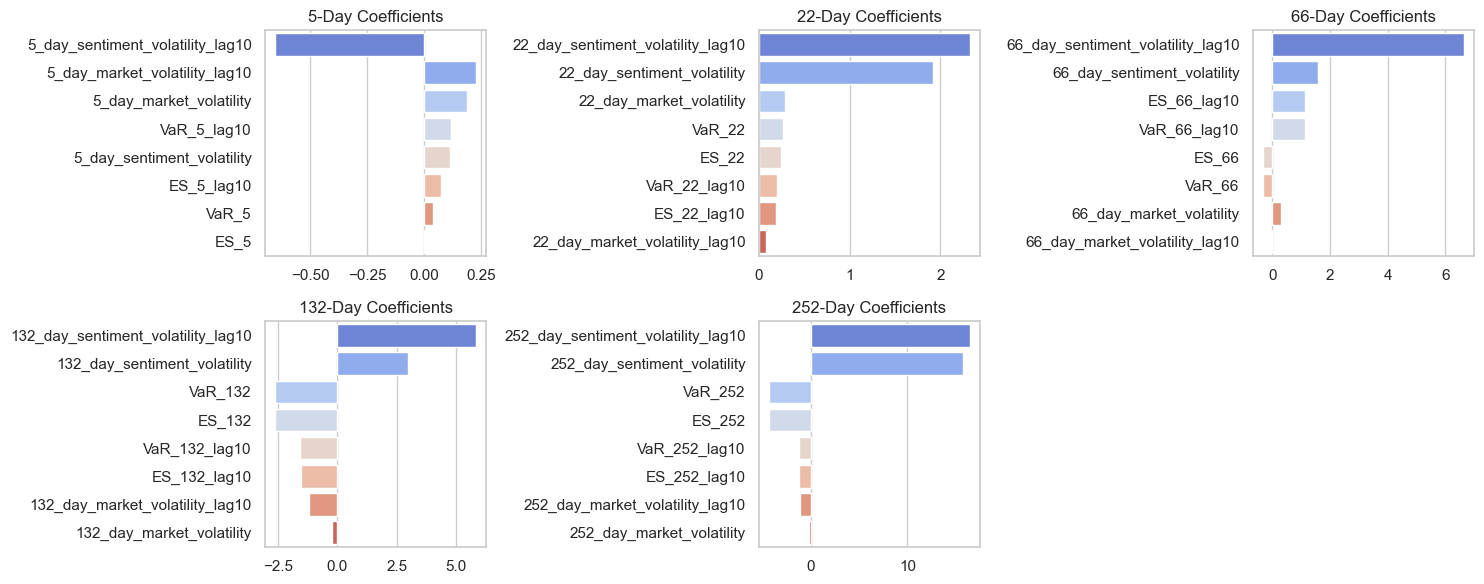

In [255]:
plot_logit_coefficients_grid(logit_results)

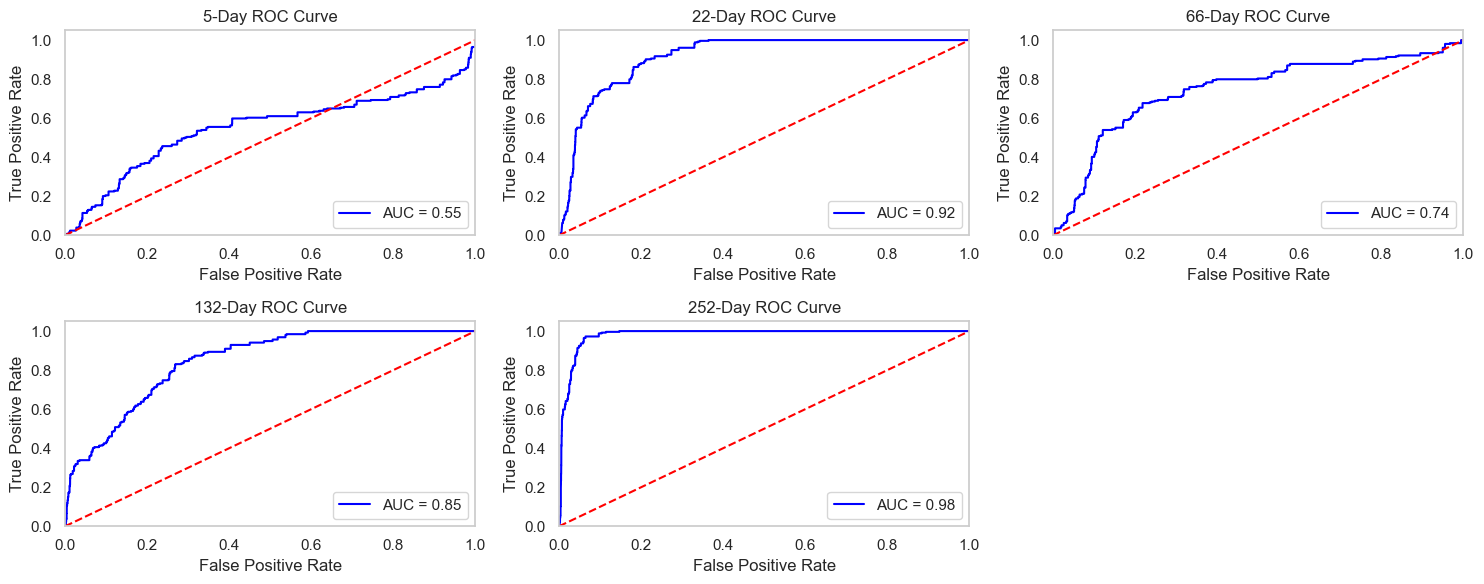

In [256]:
plot_roc_curves_grid(logit_results, X_test_dict, y_test_dict)

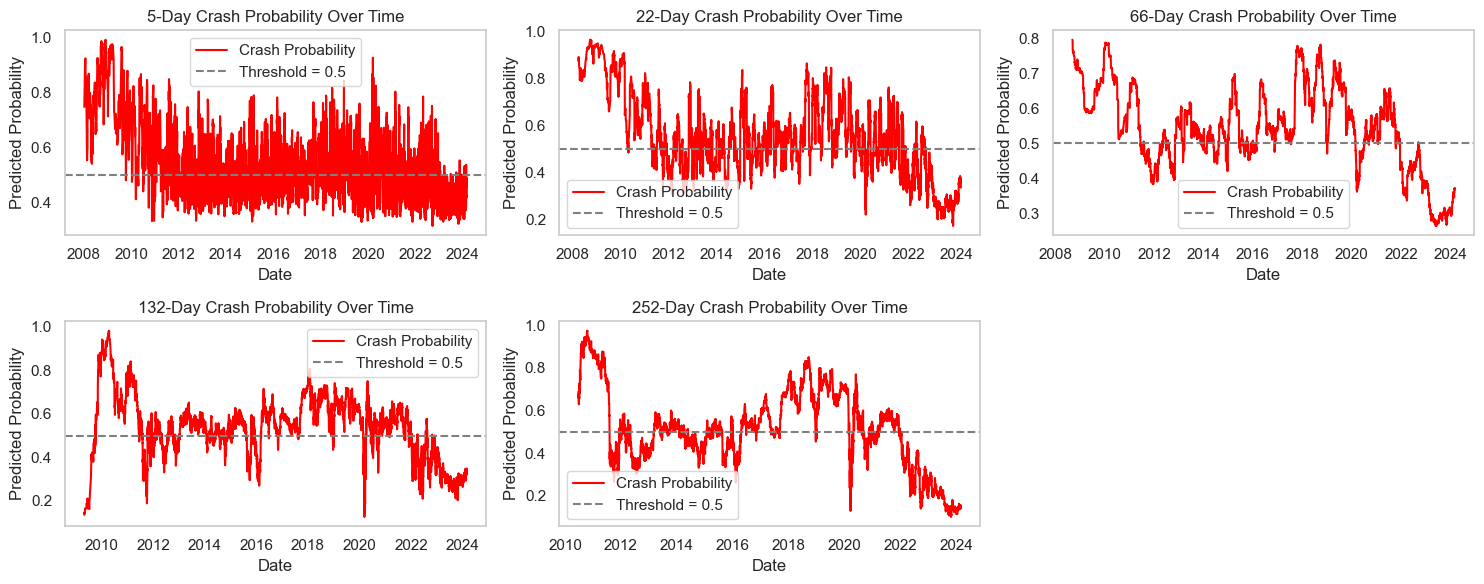

In [257]:
plot_crash_probabilities_grid(logit_results, market_sentiment_data, target_col='future_crash')

### Dynamic Logit Regression with Combined Features and Dynamic Threshold

In [325]:
# Define combined feature period
combined_period = 1

# Combine 5-day and 22-day features
combined_features = [
    f'22_day_sentiment_volatility',
    f'22_day_market_volatility',
]

# Add lagged features
for feat in combined_features:
    market_sentiment_data[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

feature_cols = combined_features + [f'{f}_lag{lag}' for f in combined_features]

# Drop NA rows for these features
df_combined = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()

X = df_combined[feature_cols]
y = df_combined['future_crash']

# Split and apply SMOTE
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)
train_size = int(len(df_model) * 0.6)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
# X_resampled, y_resampled = X_train.copy(), y_train.copy()

# Fit logistic regression
logit = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=1000, 
    class_weight='balanced',
    C=1.0,
    l1_ratio=0.5)
logit.fit(X_resampled, y_resampled)

y_proba = logit.predict_proba(X_test)[:, 1]
best_thresh = dynamic_threshold_calculate(y_test, y_proba)
y_pred = (y_proba >= best_thresh).astype(int)

# Evaluation
auc_score = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, output_dict=True)

coefficients = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Store results
logit_results[combined_period] = {
    'model': logit,
    'auc_score': auc_score,
    'report': report,
    'coefficients': coefficients,
}

X_test_dict[combined_period] = X_test
y_test_dict[combined_period] = y_test

# Print summary
print(f"\n=== Combined Logit Model ===")
print(f"AUC: {auc_score:.3f}")
print("Top coefficients:")
print(coefficients)

Best threshold: 0.44, F1: 0.42

=== Combined Logit Model ===
AUC: 0.935
Top coefficients:
                             Feature  Coefficient
0        22_day_sentiment_volatility     2.809779
2  22_day_sentiment_volatility_lag10     1.595229
1           22_day_market_volatility     0.103639
3     22_day_market_volatility_lag10    -0.092179


Precision and Recall for Combined Model:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      7374
           1       0.31      0.65      0.42       254

    accuracy                           0.94      7628
   macro avg       0.65      0.80      0.69      7628
weighted avg       0.96      0.94      0.95      7628



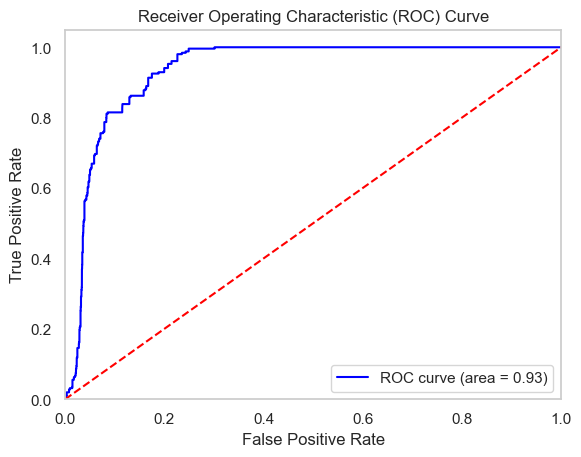

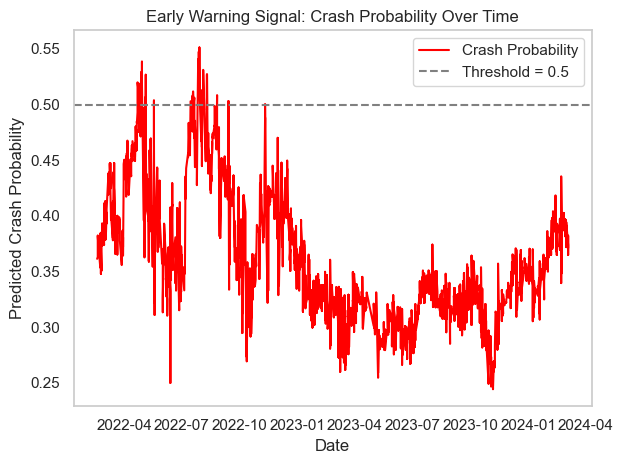

In [308]:
# Create DataFrame with dates and probabilities
dates = df_combined.loc[X_test.index, 'Date']
prob_df = pd.DataFrame({
    'Date': dates,
    'crash_probability': y_proba
}).sort_values('Date')

# Report precision and recall
print("Precision and Recall for Combined Model:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
plot_roc_curve(y_test, y_proba)

# Plot crash probabilities
plot_crash_probabilities(prob_df, target_col='crash_probability')

### CNN

In [333]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.utils import class_weight

cnn_results = {}
X_test_dict = {}
y_test_dict = {}
# Match window size to volatility periods
# window_sizes = [5, 22, 66, 126, 252]
window_size = 30  # Default window size for CNN

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Drop NA values
    df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()
    X_raw = df_model[feature_cols].fillna(0)
    y_raw = df_model['future_crash']

    # Flatten features (tabular form)
    X_flat = X_raw.values
    y_flat = y_raw.values

    # Apply SMOTE
    sm = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = sm.fit_resample(X_flat, y_flat)

    X_resampled, y_resampled = X_flat.copy(), y_flat.copy()

    # Convert back to DataFrame for convenience
    X_resampled = pd.DataFrame(X_resampled, columns=X_raw.columns)
    y_resampled = pd.Series(y_resampled, name='future_crash')

    # Create time-series sequences
    X_seq, y_seq = create_sequences(X_resampled, y_resampled, window=window_size)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, stratify=y_seq, test_size=0.2, random_state=RANDOM_STATE)


    # Define CNN model
    cnn_model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_seq.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    # Train
    cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0, 
                  )

    # Predict
    y_prob = cnn_model.predict(X_test).flatten()

    best_threshold = dynamic_threshold_calculate(y_test, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save model and results
    cnn_results[n] = {
        'model': cnn_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test,
        'y_prob': y_prob,
        'features': feature_cols,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day CNN Model ===")
    print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.14, F1: 0.58

=== 5-Day CNN Model ===
AUC: 0.924
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3664
           1       0.58      0.57      0.58       154

    accuracy                           0.97      3818
   macro avg       0.78      0.78      0.78      3818
weighted avg       0.97      0.97      0.97      3818

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.12, F1: 0.32

=== 22-Day CNN Model ===
AUC: 0.869
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3664
           1       0.29      0.34      0.31       149

    accuracy                           0.94      3813
   macro avg       0.63      0.65      0.64      3813
weighted avg       0.95      0.94      0.94      3813

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best threshold: 0.09, F1: 0.24

=== 66-Day CNN Model ===
AUC: 0.803
              precis

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


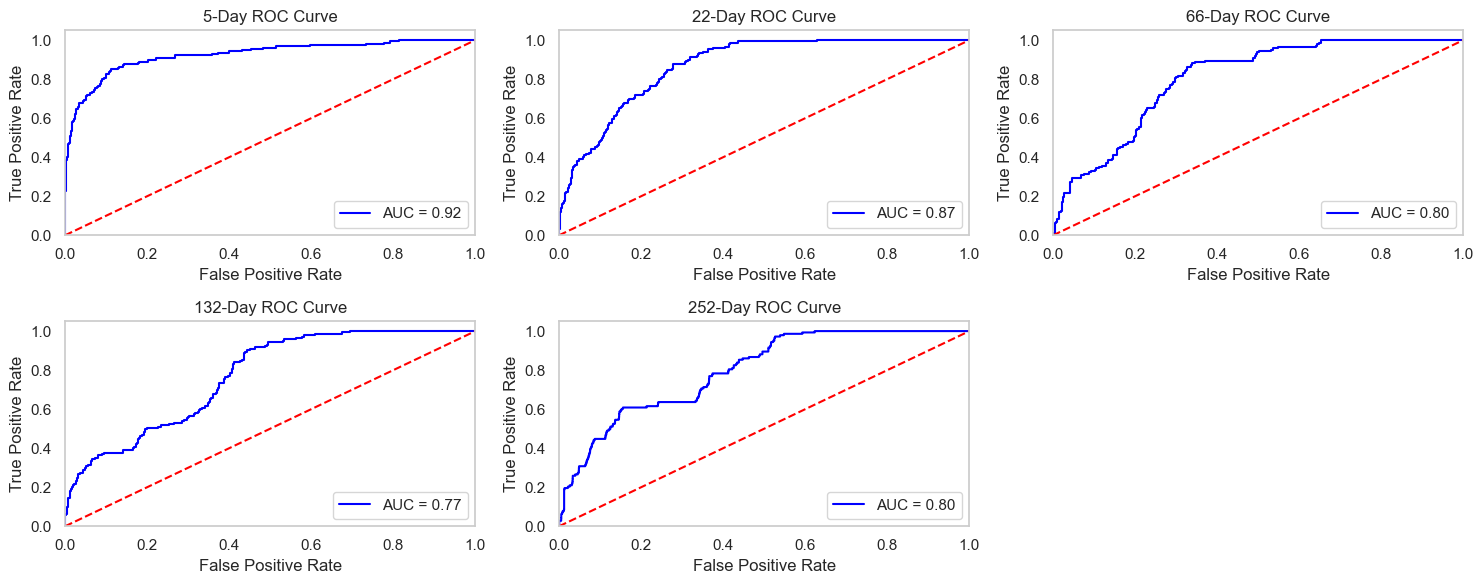

In [334]:
plot_CNN_roc_curves_grid(cnn_results, X_test_dict, y_test_dict)

597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
596/596 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step
595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step
587/587 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step


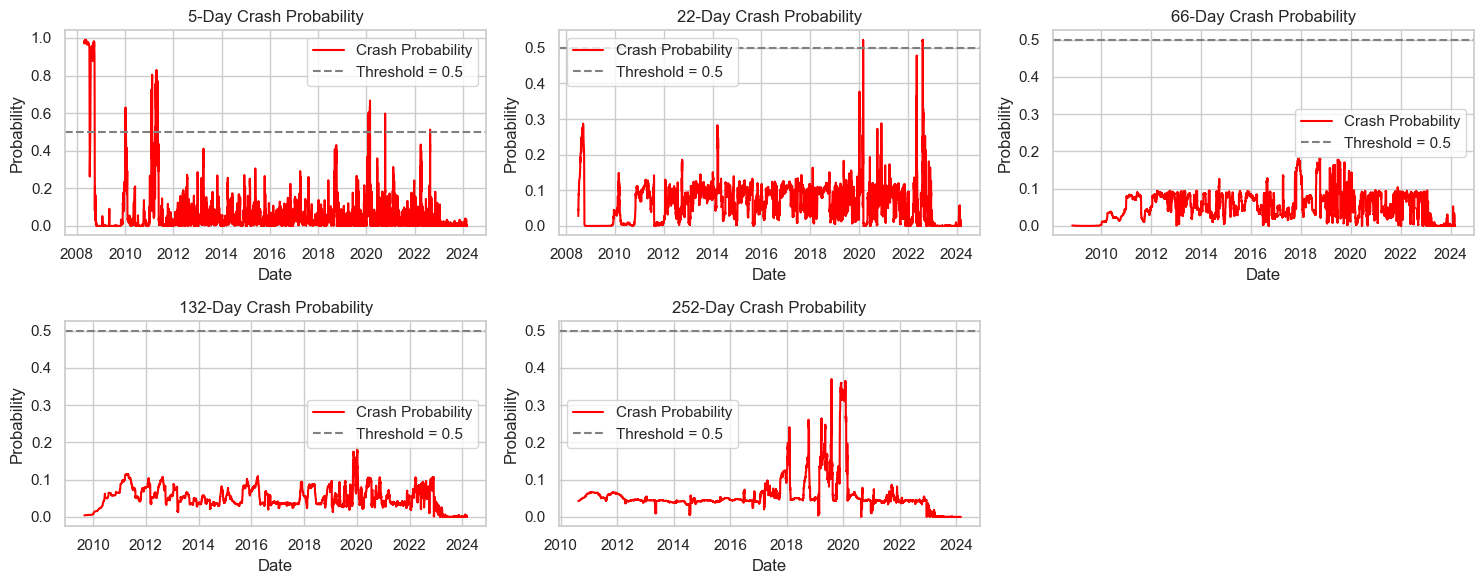

In [335]:
plot_crash_probabilities_grid_CNN(cnn_results, market_sentiment_data, window_size=window_size)

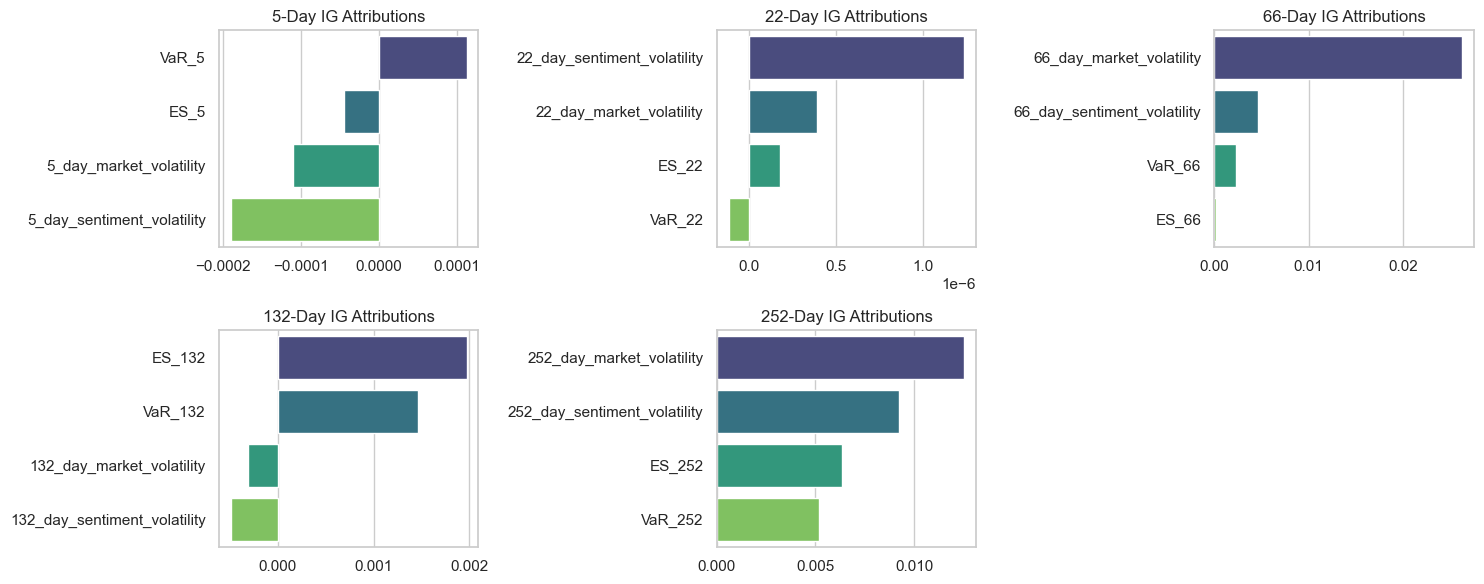

In [251]:
plot_ig_feature_attributions_grid(cnn_results, X_test_dict, window_size=window_size)

### CNN with Combined Features and Dynamic Threshold

In [ ]:
# Define combined feature period
n = 99

feature_cols = [
    f'22_day_market_volatility',
    f'22_day_sentiment_volatility',
]

# Drop NA values
df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()
X_raw = df_model[feature_cols].fillna(0)
y_raw = df_model['future_crash']

# Flatten features (tabular form)
X_flat = X_raw.values
y_flat = y_raw.values

# Apply SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = sm.fit_resample(X_flat, y_flat)

# Convert back to DataFrame for convenience
X_resampled = pd.DataFrame(X_resampled, columns=X_raw.columns)
y_resampled = pd.Series(y_resampled, name='future_crash')

# Create time-series sequences
X_seq, y_seq, sequence_indices = create_sequences(X_resampled, y_resampled, window=window_size)

# Split train/test
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_seq, y_seq, sequence_indices, stratify=y_seq, test_size=0.2, random_state=RANDOM_STATE)

# Define CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_seq.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Train
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0, 
                )

# Predict
y_prob = cnn_model.predict(X_test).flatten()

best_threshold = dynamic_threshold_calculate(y_test, y_prob)
y_pred = (y_prob > best_threshold).astype(int)

# Evaluate
auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred, output_dict=True)

# Save model and results
cnn_results[n] = {
    'model': cnn_model,
    'auc_score': auc_score,
    'report': report,
    'y_test': y_test,
    'y_prob': y_prob,
    'features': feature_cols,
}

X_test_dict[n] = X_test
y_test_dict[n] = y_test

print(f"\n=== Day CNN Model ===")
print(f"AUC: {auc:.3f}")

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.20, F1: 0.98

=== 99-Day CNN Model ===
AUC: 0.994


### LSTM

In [328]:

def create_sequences(X, y, window=30):
    Xs, ys, indices = [], [], []
    for i in range(len(X) - window):
        Xs.append(X.iloc[i:(i + window)].values)
        ys.append(y.iloc[i + window])  # predict if crash occurs after window
    return np.array(Xs), np.array(ys)

In [329]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

lstm_results = {}
X_test_dict = {}
y_test_dict = {}
# Match window size to volatility periods
# window_sizes = [5, 22, 66, 126, 252]
window_size = 30  # Default window size 

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Drop NA values
    df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()
    X_raw = df_model[feature_cols].fillna(0)
    y_raw = df_model['future_crash']

    # Flatten features (tabular form)
    X_flat = X_raw.values
    y_flat = y_raw.values

    # Apply SMOTE
    sm = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = sm.fit_resample(X_flat, y_flat)

    # Convert back to DataFrame for convenience
    X_resampled = pd.DataFrame(X_resampled, columns=X_raw.columns)
    y_resampled = pd.Series(y_resampled, name='future_crash')

    # Create time-series sequences
    X_seq, y_seq = create_sequences(X_resampled, y_resampled, window=window_size)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, stratify=y_seq, test_size=0.2, random_state=RANDOM_STATE)


    lstm_model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

    lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Predict
    y_prob = lstm_model.predict(X_test).flatten()

    best_threshold = dynamic_threshold_calculate(y_test, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save model and results
    lstm_results[n] = {
        'model': lstm_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test,
        'y_prob': y_prob,
        'features': feature_cols,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day LSTM Model ===")
    print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

Epoch 1/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.9219 - loss: 0.3160 - val_AUC: 0.9814 - val_loss: 0.1086
Epoch 2/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.9838 - loss: 0.1020 - val_AUC: 0.9821 - val_loss: 0.0998
Epoch 3/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.9854 - loss: 0.0930 - val_AUC: 0.9830 - val_loss: 0.1030
Epoch 4/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.9854 - loss: 0.0921 - val_AUC: 0.9844 - val_loss: 0.0951
Epoch 5/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.9855 - loss: 0.0897 - val_AUC: 0.9842 - val_loss: 0.0954
Epoch 6/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.9890 - loss: 0.0784 - val_AUC: 0.9854 - val_loss: 0.0908
Epoch 7/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.9882 - loss: 0.0837 - val_AUC: 0.9853 - val_loss: 0.0910
Epoch 8/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - AUC: 0.9870 - loss: 0.0834 - val_AUC: 0.9861 - val_loss: 0.0908
Epoch 9/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AU

229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


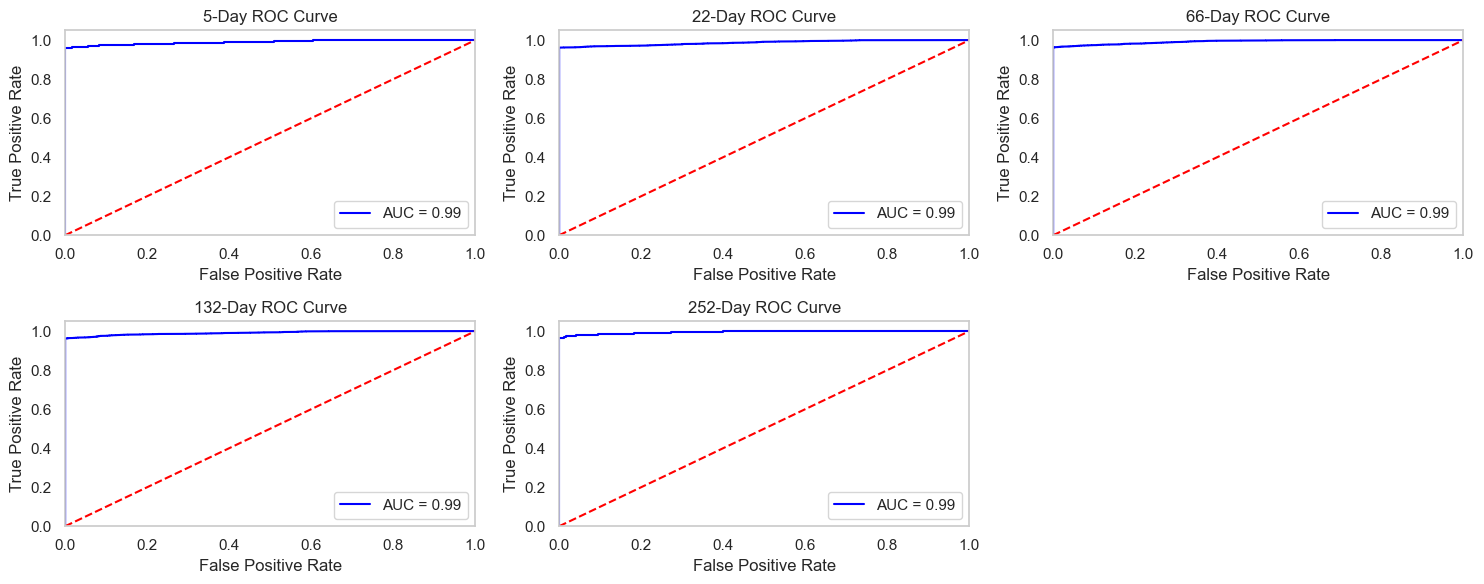

In [330]:
plot_CNN_roc_curves_grid(lstm_results, X_test_dict, y_test_dict)

597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
595/595 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


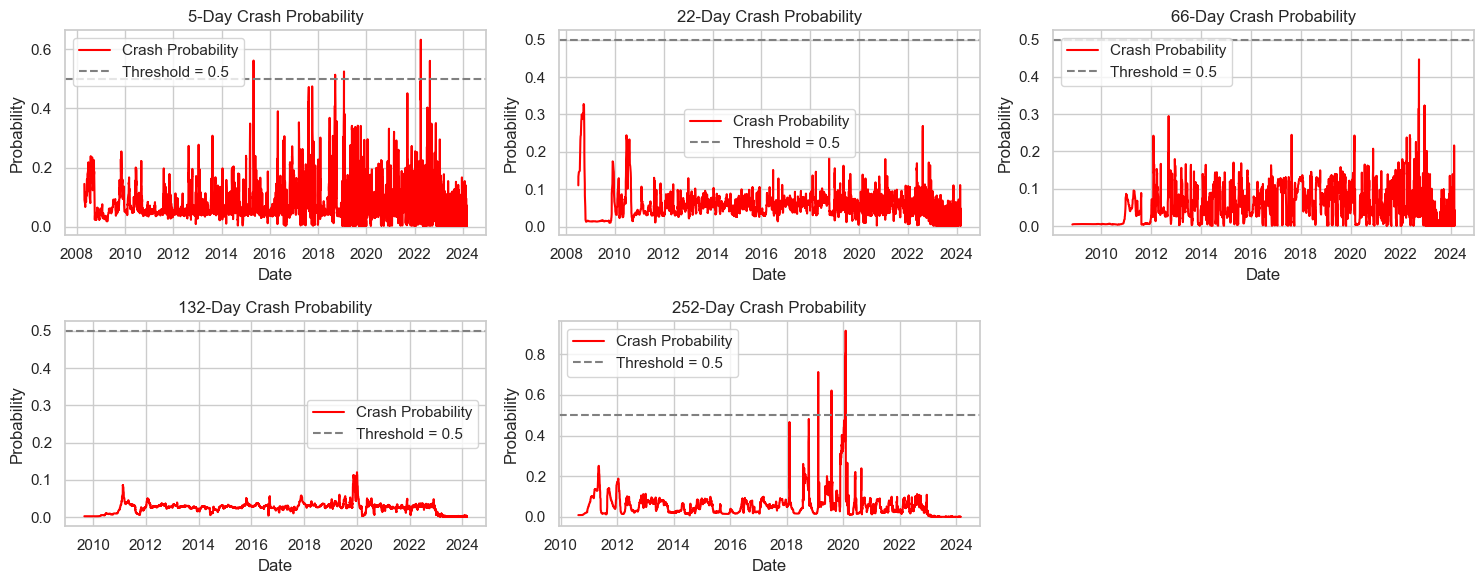

In [331]:
plot_crash_probabilities_grid_CNN(lstm_results, market_sentiment_data, window_size=window_size)

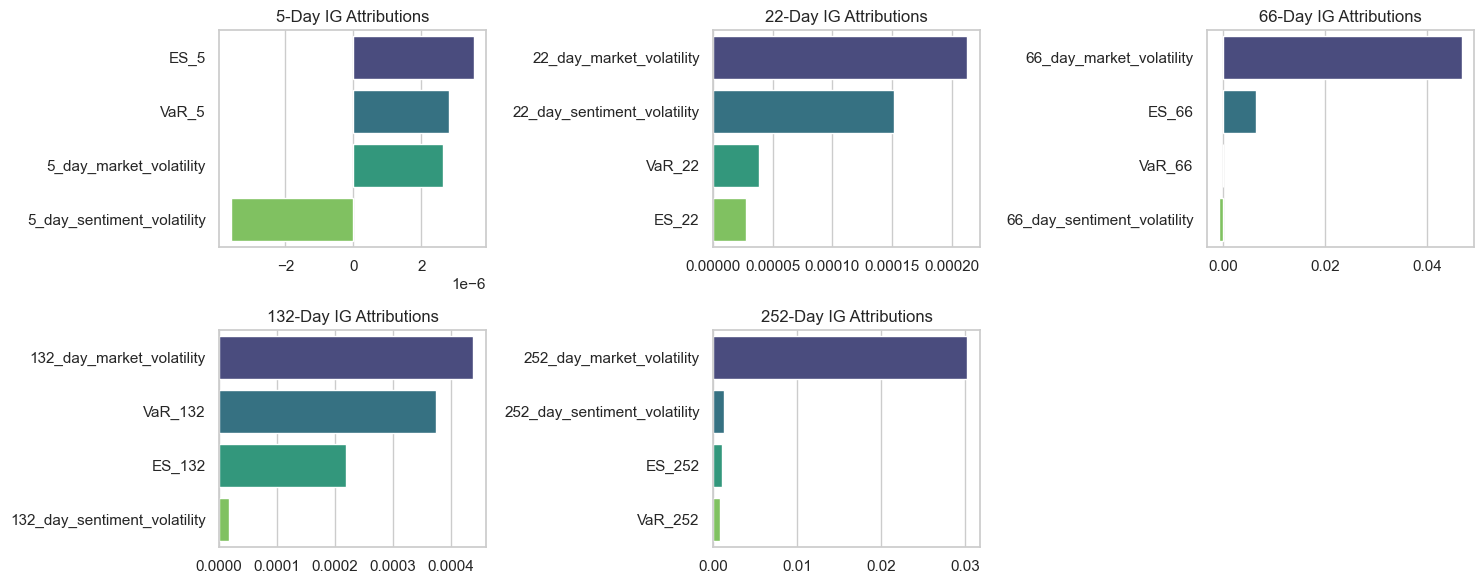

In [332]:
plot_ig_feature_attributions_grid(lstm_results, X_test_dict, window_size=window_size)

In [201]:
# Use all volatility/sentiment features
features = [col for col in market_sentiment_data.columns if 'volatility' in col]
X_raw = market_sentiment_data[features].fillna(0)
y_raw = market_sentiment_data['future_crash']

# Flatten features (tabular form)
X_flat = X_raw.values
y_flat = y_raw.values

# Apply SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = sm.fit_resample(X_flat, y_flat)

# Convert back to DataFrame for convenience
X_resampled = pd.DataFrame(X_resampled, columns=X_raw.columns)
y_resampled = pd.Series(y_resampled, name='future_crash')

# Create time-series sequences
X_seq, y_seq = create_sequences(X_resampled, y_resampled, window=window_size)

# Create sequences
window_size = 22
X_seq, y_seq = create_sequences(X_raw, y_raw, window=window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=RANDOM_STATE)

In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5112 - loss: 0.1984 - val_AUC: 0.6251 - val_loss: 0.1589
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6635 - loss: 0.1491 - val_AUC: 0.7626 - val_loss: 0.1563
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7222 - loss: 0.1523 - val_AUC: 0.7647 - val_loss: 0.1456
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7452 - loss: 0.1484 - val_AUC: 0.7898 - val_loss: 0.1442
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7744 - loss: 0.1430 - val_AUC: 0.8035 - val_loss: 0.1343
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.7922 - loss: 0.1346 - val_AUC: 0.8484 - val_loss: 0.1320
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.7831 - loss: 0.1480 - val_AUC: 0.8391 - val_loss: 0.1387
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.8008 - loss: 0.1359 - val_AUC: 0.8467 - val_loss: 0.1320
Epoch 9/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AU

In [203]:
y_prob = lstm_model.predict(X_test).flatten()
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3664
           1       1.00      0.08      0.14       157

    accuracy                           0.96      3821
   macro avg       0.98      0.54      0.56      3821
weighted avg       0.96      0.96      0.95      3821



598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


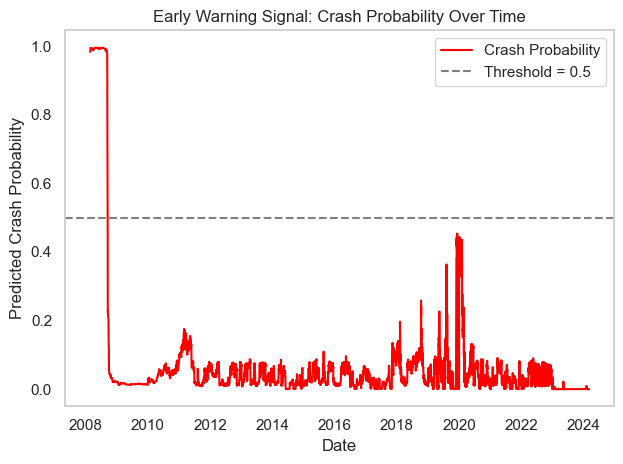

In [204]:
crash_prob = lstm_model.predict(X_seq).flatten()
df_model = market_sentiment_data.copy()
df_plot = df_model.iloc[window_size:].copy()
df_plot['crash_probability'] = crash_prob

plot_crash_probabilities(df_plot, target_col='crash_probability')

## Early Warning System

In [205]:
# Function for early warning signal
def early_warning_signal(new_data, logit_model, threshold=0.5):
    # Select latest row (most recent date)
    latest_row = new_data[feature_cols].iloc[[-1]]  # 2D array format
    crash_probability = logit_model.predict_proba(latest_row)[0, 1]
    warning_flag = int(crash_probability >= threshold)

    return crash_probability, warning_flag

In [206]:
def dynamic_threshold(proba_history, quantile=0.95):
    return np.quantile(proba_history, quantile)

In [207]:
# # Assume your daily updated data
# warning_results = []

# for i in range(len(market_sentiment_data)):
#     # Slice data up to day i
#     daily_data = market_sentiment_data.iloc[:i+1].copy()

#     # Drop rows with NA so features can be calculated
#     if daily_data[feature_cols].iloc[-1].isna().any():
#         continue

#     # Predict
#     prob, flag = early_warning_signal(daily_data, logit, threshold=0.5)
#     warning_results.append({
#         'Date': daily_data['Date'].iloc[-1],
#         'Crash_Probability': prob,
#         'Warning': flag
#     })

# # Convert to DataFrame
# warnings_df = pd.DataFrame(warning_results)

In [208]:
# plt.figure(figsize=(14, 6))
# plt.plot(warnings_df['Date'], warnings_df['Crash_Probability'], label='Crash Probability', color='red')
# plt.axhline(0.5, linestyle='--', color='gray', label='Threshold = 0.5')
# plt.fill_between(warnings_df['Date'], 0, 1, where=warnings_df['Warning']==1, color='red', alpha=0.1, label='Warning Zone')
# plt.xlabel("Date")
# plt.ylabel("Crash Probability")
# plt.title("Real-Time Early Warning System")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

In [209]:
# latest_window = X_raw.tail(window_size).values.reshape(1, window_size, -1)
# crash_prob_today = model.predict(latest_window)[0][0]

# print(f"Crash Probability Today: {crash_prob_today:.2%}")